<a href="https://colab.research.google.com/github/doanchung1612/SpeechEmotionRecognition/blob/master/CNN_emotion_recognition_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  # **Import libs**

In [0]:
import os
import random
import sys

#package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import plotly.graph_objs as go 
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected =True)

#Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer 
from keras.utils import np_utils
from keras.utils import to_categorical

#Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

#Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

input_duration = 3
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/AI/Speech Emotion Recognition (SER)'
print("oke")


Found GPU at: /device:GPU:0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
oke


# **Reading data**

In [0]:
link = root_path+ '/data/Audio_Speech_Actors_01-24/'
dir_list = os.listdir(link)
dir_list.sort()
print(dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [0]:
#Created dataFrame for data intel
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0;
for i in dir_list:
  file_list = os.listdir(link +i)
  for f in file_list:
    nm = f.split('.')[0].split('-')
    path = 'data/' + i +'/' + f
    src = int(nm[1])
    actor = int(nm[-1])
    emotion = int(nm[2])
    
    if int(actor)%2 ==0:
      gender ="female"
    else: 
      gender = "male"
      
    if nm[3] =='01':
      intensity = 0
    else:
      intensity = 1
      
    if nm[4] =='01':
      statement = 0
    else:
      statement = 1
    if nm[5] == '01':
      repeat = 0
    else:
      repeat = 1
    
    data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
    count += 1
      

In [0]:
print(len(data_df))
data_df.head()

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,data/Actor_01/03-01-07-02-02-02-01.wav,1,1,male,1,1,1,7
1,data/Actor_01/03-01-06-02-02-01-01.wav,1,1,male,1,1,0,6
2,data/Actor_01/03-01-05-02-01-02-01.wav,1,1,male,1,0,1,5
3,data/Actor_01/03-01-03-01-02-01-01.wav,1,1,male,0,1,0,3
4,data/Actor_01/03-01-05-02-02-02-01.wav,1,1,male,1,1,1,5


# **Plotting the audio file's waveform and its spectrogram**

In [0]:
file_name = data_df.path[1011].replace('data/','')
print(file_name)

samples, sample_rate = librosa.load(link+file_name)
sample_rate, samples

Actor_17/03-01-08-01-01-01-17.wav


(22050, array([-7.0581031e-08, -2.5548841e-08,  1.6240570e-07, ...,
         1.5991445e-04,  1.7141545e-04,  0.0000000e+00], dtype=float32))

In [0]:
len(samples), sample_rate

(75045, 22050)

In [0]:
def log_specgram (audio, sample_rate, window_size =20, step_size =10, eps = 1e-10):
  nperseg = int(round(window_size * sample_rate / 1e3))
  noverlap = int(round(step_size * sample_rate /1e3 ))
  freqs, times, spec = signal.spectrogram(audio, 
                                         fs = sample_rate,
                                         window ='hann',
                                         nperseg = nperseg,
                                         noverlap = noverlap,
                                         detrend = False)
  return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [0]:
sample_rate/len(samples)

0.2938237057765341

Text(0.5, 0, 'Seconds')

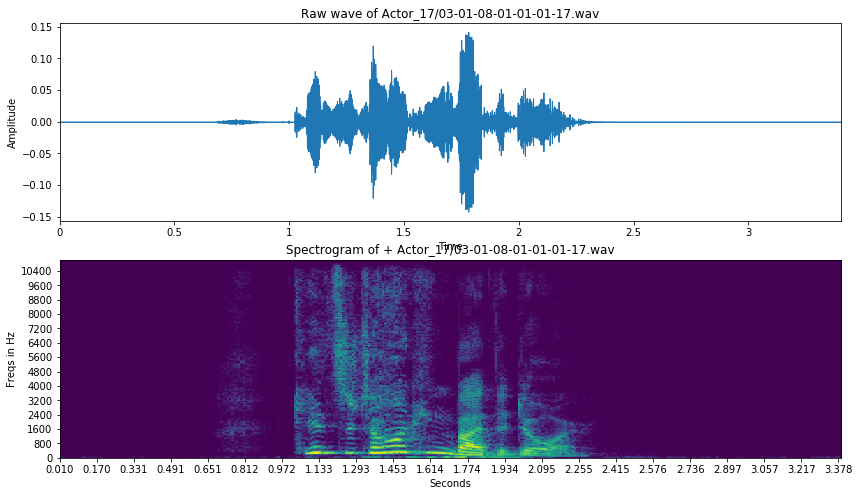

In [0]:
#plotting waveform and spectrogram
freqs, times , spectrogram = log_specgram(samples, sample_rate)

fig =plt.figure(figsize =(14,8))

ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + file_name)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr = sample_rate)

ax2 =fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect ='auto', origin = 'lower', extent = [times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of + ' + file_name)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')


In [0]:
mean = np.mean(spectrogram, axis =0)
std = np.std(spectrogram, axis =0)
spectrogram = (spectrogram - mean)/std

In [0]:
#trim the silence voice
aa, bb = librosa.effects.trim(samples, top_db=30)
aa,bb

(array([-2.31037906e-04,  9.27544461e-05, -1.40071206e-04, ...,
         2.40739202e-04,  1.51262475e-05, -1.48833366e-04], dtype=float32),
 array([22016, 50688]))

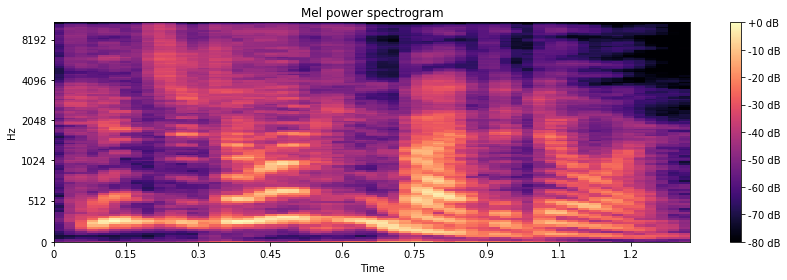

In [0]:
#plotting Mel power spectrogram
S = librosa.feature.melspectrogram(aa, sr= sample_rate, n_mels = 128)

#convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref= np.max)

plt.figure(figsize = (12,4))
librosa.display.specshow(log_S, sr= sample_rate, x_axis = 'time', y_axis ='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format ='%+02.0f dB')
plt.tight_layout()


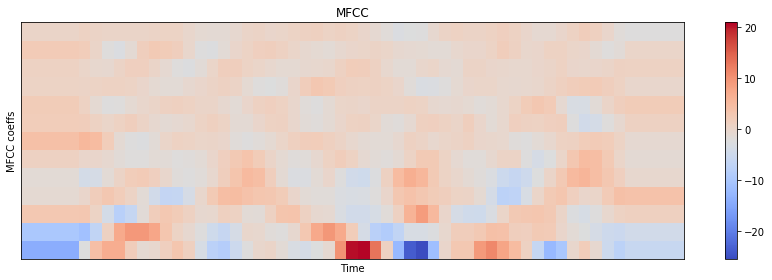

In [0]:
#plotting mfcc
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc =13)

#Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order =2 )

plt.figure(figsize =(12,4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [0]:
#Original sound
ipd.Audio(samples, rate = sample_rate)

In [0]:
#silence trimmed sound by librosa.effects.trim()
ipd.Audio(aa,rate= sample_rate)

In [0]:
#silence trimmed sound by manuel trimming 
sample_cut = samples[10000:-12500]
ipd.Audio(sample_cut, rate= sample_rate)

# **Defining the truth label**

In [0]:
# 2 class : Positive, Negative

#Poss: clam, happy
#Nega: Angry, fearful, sad

label2_list =[]
for i in range(len(data_df)):
  if data_df.emotion[i] ==2: #Clam
    lb = '_positive'
  elif data_df.emotion[i] ==3: #Happy
    lb = '_positive'
  elif data_df.emotion[i] == 4: # Sad
    lb ='_negative'
  elif data_df.emotion[i] == 5: # Angry
    lb ='_negative'
  elif data_df.emotion[i] == 6: # Fearful
    lb ='_negative'
  else:
    lb='_none'
    
  #Add gender to the label
  label2_list.append(data_df.gender[i]+ lb)
len(label2_list)

1440

In [0]:
#3 class: positive, neutral & negative

#Poss: Happy
#Nega: Angry, fearful, sad
#Neutral: Clam, neutral

label3_list = []
for i in range(len(data_df)):
  if data_df.emotion[i] == 1: #Neutral
    lb= '_neutral'
  elif data_df.emotion[i] == 2: #Clam
    lb= '_neutral'
  elif data_df.emotion[i] == 3: #Happy
    lb= '_positive'
  elif data_df.emotion[i] == 4: #Sad
    lb= '_negative'
  elif data_df.emotion[i] == 5: #Angry
    lb= '_negative'
  elif data_df.emotion[i] == 6: #FearFul
    lb= '_negative'
  else:
    lb ='_none'
  
  #Add gender to label
  label3_list.append(data_df.gender[i] + lb)
len(label3_list)
    

1440

In [0]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

1440

In [0]:
# print(label8_list)
# labels = pd.DataFrame(label5_list)
# print(labels)

In [0]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)
print(len(label8_list))
# print(label8_list)

1440


In [0]:
# Select the label set you want by commenting the unwanteds.

# data_df['label'] = label2_list
# data_df['label'] = label3_list
data_df['label'] = label5_list
# data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,data/Actor_01/03-01-07-02-02-02-01.wav,1,1,male,1,1,1,7,male_none
1,data/Actor_01/03-01-06-02-02-01-01.wav,1,1,male,1,1,0,6,male_fearful
2,data/Actor_01/03-01-05-02-01-02-01.wav,1,1,male,1,0,1,5,male_angry
3,data/Actor_01/03-01-03-01-02-01-01.wav,1,1,male,0,1,0,3,male_happy
4,data/Actor_01/03-01-05-02-02-02-01.wav,1,1,male,1,1,1,5,male_angry


In [0]:
print(data_df.label.value_counts().keys())

Index(['female_none', 'male_none', 'female_happy', 'male_fearful',
       'female_sad', 'female_calm', 'female_fearful', 'male_angry',
       'male_calm', 'female_angry', 'male_sad', 'male_happy'],
      dtype='object')


In [0]:
#plotting the emotion distribution
def plot_emotion_dist(dist, color_code='#C2185B', title= 'Plot'):
  
  tmp_dataFrame = pd.DataFrame()
#   print(list(dist.keys()))
  print(dist)
  tmp_dataFrame['Emotion'] = list(dist.keys())
  tmp_dataFrame['Count'] = list(dist)
  fig, ax = plt.subplots(figsize = (14,7))
  
  ax= sns.barplot(x="Emotion", y ="Count", color= color_code, data= tmp_dataFrame)
  ax.set_title(title)
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    
  

female_none       240
male_none         240
female_happy       96
male_fearful       96
female_sad         96
female_calm        96
female_fearful     96
male_angry         96
male_calm          96
female_angry       96
male_sad           96
male_happy         96
Name: label, dtype: int64


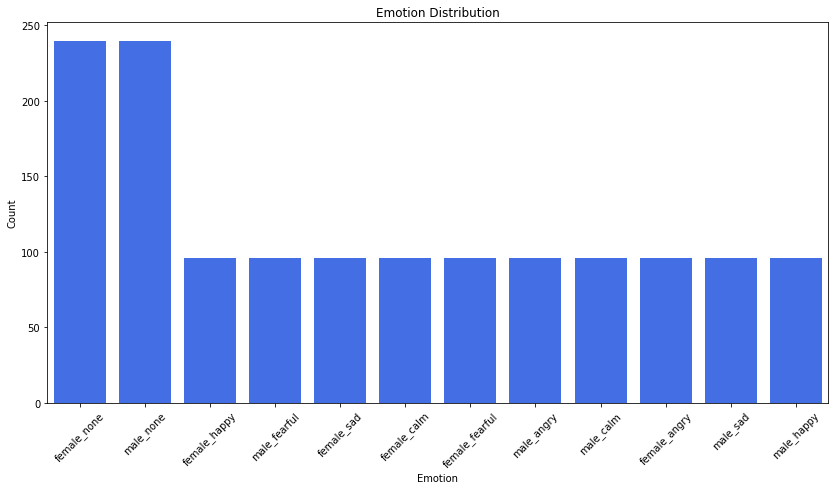

In [0]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF","Emotion Distribution")

# **Data Splitting**


In [0]:
# Female Data Set

## Uncomment all below to use Female set 

data2_df_fm = data_df.copy()
data2_df_fm = data2_df_fm[data2_df_fm.label != "male_none"]
data2_df_fm = data2_df_fm[data2_df_fm.label != "female_none"]
data2_df_fm = data2_df_fm[data2_df_fm.label != "male_happy"]
data2_df_fm = data2_df_fm[data2_df_fm.label != "male_angry"]
data2_df_fm = data2_df_fm[data2_df_fm.label != "male_sad"]
data2_df_fm = data2_df_fm[data2_df_fm.label != "male_fearful"]
data2_df_fm = data2_df_fm[data2_df_fm.label != "male_calm"]
data2_df_fm = data2_df_fm[data2_df_fm.label != "male_positive"]
data2_df_fm = data2_df_fm[data2_df_fm.label != "male_negative"].reset_index(drop=True)

tmp1 = data2_df_fm[data2_df_fm.actor == 22]
tmp2 = data2_df_fm[data2_df_fm.actor == 24]
data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
data2_df_fm = data2_df_fm[data2_df_fm.actor != 22]
data2_df_fm = data2_df_fm[data2_df_fm.actor != 24].reset_index(drop=True)
print (len(data2_df_fm))
data2_df_fm.head()
# print(data2_df_fm.label)

400


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,data/Actor_02/03-01-05-01-02-01-02.wav,1,2,female,0,1,0,5,female_angry
1,data/Actor_02/03-01-03-02-02-02-02.wav,1,2,female,1,1,1,3,female_happy
2,data/Actor_02/03-01-02-02-02-02-02.wav,1,2,female,1,1,1,2,female_calm
3,data/Actor_02/03-01-04-02-02-01-02.wav,1,2,female,1,1,0,4,female_sad
4,data/Actor_02/03-01-03-01-01-01-02.wav,1,2,female,0,0,0,3,female_happy


In [0]:
#Male Data set

#Uncomment all below to use Male set
data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop = True)

tmp1 = data2_df[data2_df.actor ==21]
tmp2 = data2_df[data2_df.actor ==22]
tmp3 = data2_df[data2_df.actor ==23]
tmp4 = data2_df[data2_df.actor ==24]

data3_df = pd.concat( [tmp1, tmp3], ignore_index = True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop = True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop= True)

print(len(data2_df))
data2_df.head()

400


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,data/Actor_01/03-01-06-02-02-01-01.wav,1,1,male,1,1,0,6,male_fearful
1,data/Actor_01/03-01-05-02-01-02-01.wav,1,1,male,1,0,1,5,male_angry
2,data/Actor_01/03-01-03-01-02-01-01.wav,1,1,male,0,1,0,3,male_happy
3,data/Actor_01/03-01-05-02-02-02-01.wav,1,1,male,1,1,1,5,male_angry
4,data/Actor_01/03-01-02-01-02-01-01.wav,1,1,male,0,1,0,2,male_calm


In [0]:
print(len(data3_df))
data3_df.head()

80


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,data/Actor_21/03-01-04-01-02-02-21.wav,1,21,male,0,1,1,4,male_sad
1,data/Actor_21/03-01-05-02-02-02-21.wav,1,21,male,1,1,1,5,male_angry
2,data/Actor_21/03-01-06-02-01-02-21.wav,1,21,male,1,0,1,6,male_fearful
3,data/Actor_21/03-01-02-01-01-01-21.wav,1,21,male,0,0,0,2,male_calm
4,data/Actor_21/03-01-03-02-01-01-21.wav,1,21,male,1,0,0,3,male_happy


# Getting the featrues of audio file using librosa

In [0]:
data = pd.DataFrame(columns=['features'])
# print("root_path = " + root_path)
print(link)
for i in tqdm(range(len(data2_df))):
    aaa =data2_df.path[i].replace('data/','')
    url = (link+ aaa)
    print(url)
    X, sample_rate = librosa.load(url, res_type = 'kaiser_fast', duration = input_duration, sr = 22050*2, offset = 0.5 )
#X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr= sample_rate, n_mfcc= 13),axis = 0)
    feature = mfccs
    data.loc[i] = [feature]
    
# for i in tqdm(range(len(data2_df_fm))):
# # #     print(url)
# #     print((link+ data2_df.path[i]).replace('/data',''))
# #     print(data2_df.path[i])
#     aaa =data2_df_fm.path[i].replace('data/','')
# #     print(aaa)
#     url = (link+ aaa)
#     print(url)
#     X, sample_rate = librosa.load(url, res_type = 'kaiser_fast', duration = input_duration, sr = 22050*2, offset = 0.5 )
# #X = X[10000:90000]
#     sample_rate = np.array(sample_rate)
#     mfccs = np.mean(librosa.feature.mfcc(y=X, sr= sample_rate, n_mfcc= 13),axis = 0)
#     feature = mfccs
#     data.loc[i] = [feature]

  0%|          | 0/400 [00:00<?, ?it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/
gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-06-02-02-01-01.wav


  0%|          | 1/400 [00:00<05:04,  1.31it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-05-02-01-02-01.wav


  0%|          | 2/400 [00:01<04:38,  1.43it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-03-01-02-01-01.wav


  1%|          | 3/400 [00:01<03:55,  1.69it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-05-02-02-02-01.wav


  1%|          | 4/400 [00:02<03:40,  1.80it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-02-01-01.wav


  1%|▏         | 5/400 [00:02<03:37,  1.81it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-06-02-01-01-01.wav


  2%|▏         | 6/400 [00:03<03:35,  1.83it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-06-01-02-02-01.wav


  2%|▏         | 7/400 [00:06<09:04,  1.39s/it]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-04-01-02-01-01.wav


  2%|▏         | 8/400 [00:06<07:13,  1.11s/it]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-03-02-01-01-01.wav


  2%|▏         | 9/400 [00:07<06:11,  1.05it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-02-02-02-02-01.wav


  2%|▎         | 10/400 [00:07<05:03,  1.28it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-04-02-01-02-01.wav


  3%|▎         | 11/400 [00:08<04:36,  1.41it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-06-01-01-01-01.wav


  3%|▎         | 12/400 [00:08<03:59,  1.62it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-05-01-02-01-01.wav


  3%|▎         | 13/400 [00:09<03:47,  1.70it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-05-01-01-01-01.wav


  4%|▎         | 14/400 [00:09<03:27,  1.86it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-01-01-01.wav


  4%|▍         | 15/400 [00:10<03:09,  2.03it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-03-02-02-02-01.wav


  4%|▍         | 16/400 [00:10<03:20,  1.92it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-04-01-01-02-01.wav


  4%|▍         | 17/400 [00:11<03:57,  1.61it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-03-01-02-02-01.wav


  4%|▍         | 18/400 [00:12<03:26,  1.85it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-01-02-01.wav


  5%|▍         | 19/400 [00:12<03:18,  1.92it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-04-02-02-02-01.wav


  5%|▌         | 20/400 [00:12<03:01,  2.09it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-04-01-01-01-01.wav


  5%|▌         | 21/400 [00:13<03:13,  1.95it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-06-01-02-01-01.wav


  6%|▌         | 22/400 [00:13<03:02,  2.07it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-06-02-02-02-01.wav


  6%|▌         | 23/400 [00:14<02:52,  2.18it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-03-01-01-01-01.wav


  6%|▌         | 24/400 [00:14<03:04,  2.03it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-02-02-01-01-01.wav


  6%|▋         | 25/400 [00:15<02:55,  2.14it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-03-02-01-02-01.wav


  6%|▋         | 26/400 [00:15<03:02,  2.05it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-04-02-02-01-01.wav


  7%|▋         | 27/400 [00:16<02:48,  2.21it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-06-01-01-02-01.wav


  7%|▋         | 28/400 [00:16<02:53,  2.14it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-02-02-01-02-01.wav


  7%|▋         | 29/400 [00:17<03:08,  1.97it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-03-02-02-01-01.wav


  8%|▊         | 30/400 [00:17<03:04,  2.01it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-03-01-01-02-01.wav


  8%|▊         | 31/400 [00:18<03:05,  1.99it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-05-01-02-02-01.wav


  8%|▊         | 32/400 [00:18<02:55,  2.10it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-05-02-01-01-01.wav


  8%|▊         | 33/400 [00:19<03:07,  1.96it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-06-02-01-02-01.wav


  8%|▊         | 34/400 [00:19<03:00,  2.03it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-04-01-02-02-01.wav


  9%|▉         | 35/400 [00:20<03:15,  1.87it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-05-02-02-01-01.wav


  9%|▉         | 36/400 [00:20<02:59,  2.03it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-05-01-01-02-01.wav


  9%|▉         | 37/400 [00:21<03:06,  1.95it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-02-02-02-01-01.wav


 10%|▉         | 38/400 [00:21<02:54,  2.07it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-04-02-01-01-01.wav


 10%|▉         | 39/400 [00:22<02:50,  2.12it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-02-02-01.wav


 10%|█         | 40/400 [00:22<02:42,  2.22it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-02-01-01-02-03.wav


 10%|█         | 41/400 [00:23<03:06,  1.93it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-06-02-02-02-03.wav


 10%|█         | 42/400 [00:23<02:54,  2.05it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-02-02-02-02-03.wav


 11%|█         | 43/400 [00:24<02:41,  2.21it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-03-02-02-01-03.wav


 11%|█         | 44/400 [00:24<02:41,  2.20it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-05-02-02-02-03.wav


 11%|█▏        | 45/400 [00:24<02:40,  2.21it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-05-01-01-01-03.wav


 12%|█▏        | 46/400 [00:25<02:41,  2.19it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-05-02-02-01-03.wav


 12%|█▏        | 47/400 [00:25<02:33,  2.29it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-04-02-01-01-03.wav


 12%|█▏        | 48/400 [00:26<02:27,  2.38it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-06-02-02-01-03.wav


 12%|█▏        | 49/400 [00:26<02:36,  2.25it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-02-01-01-01-03.wav


 12%|█▎        | 50/400 [00:27<02:35,  2.24it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-05-01-01-02-03.wav


 13%|█▎        | 51/400 [00:27<02:57,  1.97it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-03-01-02-02-03.wav


 13%|█▎        | 52/400 [00:28<03:07,  1.86it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-05-02-01-02-03.wav


 13%|█▎        | 53/400 [00:28<03:05,  1.87it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-02-02-01-01-03.wav


 14%|█▎        | 54/400 [00:30<04:26,  1.30it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-03-02-02-02-03.wav


 14%|█▍        | 55/400 [00:30<03:49,  1.51it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-04-01-01-01-03.wav


 14%|█▍        | 56/400 [00:31<03:45,  1.53it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-04-02-02-01-03.wav


 14%|█▍        | 57/400 [00:31<03:33,  1.61it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-02-02-01-02-03.wav


 14%|█▍        | 58/400 [00:32<03:12,  1.78it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-04-01-01-02-03.wav


 15%|█▍        | 59/400 [00:32<02:59,  1.90it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-04-01-02-02-03.wav


 15%|█▌        | 60/400 [00:33<02:57,  1.92it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-06-02-01-01-03.wav


 15%|█▌        | 61/400 [00:33<02:57,  1.91it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-05-01-02-02-03.wav


 16%|█▌        | 62/400 [00:34<02:55,  1.93it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-03-02-01-02-03.wav


 16%|█▌        | 63/400 [00:34<02:58,  1.89it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-03-01-01-02-03.wav


 16%|█▌        | 64/400 [00:35<03:27,  1.62it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-04-02-01-02-03.wav


 16%|█▋        | 65/400 [00:36<03:05,  1.81it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-03-01-01-01-03.wav


 16%|█▋        | 66/400 [00:36<02:48,  1.99it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-04-01-02-01-03.wav


 17%|█▋        | 67/400 [00:36<02:38,  2.09it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-04-02-02-02-03.wav


 17%|█▋        | 68/400 [00:37<02:32,  2.18it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-06-01-02-01-03.wav


 17%|█▋        | 69/400 [00:37<02:32,  2.17it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-02-02-02-01-03.wav


 18%|█▊        | 70/400 [00:38<02:50,  1.94it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-06-02-01-02-03.wav


 18%|█▊        | 71/400 [00:38<02:44,  2.01it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-06-01-02-02-03.wav


 18%|█▊        | 72/400 [00:39<02:41,  2.03it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-03-01-02-01-03.wav


 18%|█▊        | 73/400 [00:39<02:44,  1.98it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-02-01-02-01-03.wav


 18%|█▊        | 74/400 [00:40<02:43,  1.99it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-06-01-01-01-03.wav


 19%|█▉        | 75/400 [00:40<02:37,  2.07it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-03-02-01-01-03.wav


 19%|█▉        | 76/400 [00:41<02:28,  2.18it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-05-01-02-01-03.wav


 19%|█▉        | 77/400 [00:41<02:32,  2.12it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-06-01-01-02-03.wav


 20%|█▉        | 78/400 [00:42<02:36,  2.06it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-05-02-01-01-03.wav


 20%|█▉        | 79/400 [00:42<02:40,  2.00it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_03/03-01-02-01-02-02-03.wav


 20%|██        | 80/400 [00:43<02:41,  1.98it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-06-01-02-01-05.wav


 20%|██        | 81/400 [00:43<03:01,  1.75it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-05-01-01-02-05.wav


 20%|██        | 82/400 [00:44<02:55,  1.81it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-04-01-02-02-05.wav


 21%|██        | 83/400 [00:44<02:45,  1.92it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-04-02-01-01-05.wav


 21%|██        | 84/400 [00:45<02:36,  2.02it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-04-02-01-02-05.wav


 21%|██▏       | 85/400 [00:46<03:05,  1.70it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-05-02-01-02-05.wav


 22%|██▏       | 86/400 [00:46<02:46,  1.89it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-06-02-01-02-05.wav


 22%|██▏       | 87/400 [00:46<02:33,  2.04it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-03-02-02-01-05.wav


 22%|██▏       | 88/400 [00:47<02:42,  1.92it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-03-01-01-02-05.wav


 22%|██▏       | 89/400 [00:47<02:29,  2.08it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-03-02-02-02-05.wav


 22%|██▎       | 90/400 [00:48<02:34,  2.00it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-02-01-01-01-05.wav


 23%|██▎       | 91/400 [00:48<02:29,  2.06it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-02-01-02-01-05.wav


 23%|██▎       | 92/400 [00:49<02:24,  2.13it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-05-01-02-02-05.wav


 23%|██▎       | 93/400 [00:49<02:18,  2.21it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-05-02-02-01-05.wav


 24%|██▎       | 94/400 [00:50<02:13,  2.29it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-02-02-02-01-05.wav


 24%|██▍       | 95/400 [00:50<02:10,  2.34it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-04-01-02-01-05.wav


 24%|██▍       | 96/400 [00:50<02:08,  2.37it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-05-01-01-01-05.wav


 24%|██▍       | 97/400 [00:51<02:02,  2.48it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-02-02-01-01-05.wav


 24%|██▍       | 98/400 [00:51<02:06,  2.39it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-04-02-02-02-05.wav


 25%|██▍       | 99/400 [00:52<02:05,  2.40it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-06-01-01-01-05.wav


 25%|██▌       | 100/400 [00:52<02:06,  2.37it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-02-01-02-02-05.wav


 25%|██▌       | 101/400 [00:53<02:07,  2.34it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-06-01-01-02-05.wav


 26%|██▌       | 102/400 [00:53<02:12,  2.25it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-06-01-02-02-05.wav


 26%|██▌       | 103/400 [00:54<02:16,  2.17it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-02-01-01-02-05.wav


 26%|██▌       | 104/400 [00:54<02:14,  2.20it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-04-02-02-01-05.wav


 26%|██▋       | 105/400 [00:54<02:11,  2.24it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-05-02-02-02-05.wav


 26%|██▋       | 106/400 [00:55<02:22,  2.06it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-05-02-01-01-05.wav


 27%|██▋       | 107/400 [00:55<02:12,  2.21it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-02-02-01-02-05.wav


 27%|██▋       | 108/400 [00:56<02:22,  2.04it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-03-02-01-01-05.wav


 27%|██▋       | 109/400 [00:56<02:12,  2.19it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-06-02-02-01-05.wav


 28%|██▊       | 110/400 [00:57<02:22,  2.04it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-03-02-01-02-05.wav


 28%|██▊       | 111/400 [00:58<02:31,  1.90it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-02-02-02-02-05.wav


 28%|██▊       | 112/400 [00:58<02:27,  1.95it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-03-01-02-02-05.wav


 28%|██▊       | 113/400 [00:59<02:36,  1.83it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-04-01-01-01-05.wav


 28%|██▊       | 114/400 [00:59<02:29,  1.91it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-06-02-02-02-05.wav


 29%|██▉       | 115/400 [01:00<02:22,  2.00it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-03-01-01-01-05.wav


 29%|██▉       | 116/400 [01:00<02:12,  2.14it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-06-02-01-01-05.wav


 29%|██▉       | 117/400 [01:00<02:20,  2.01it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-05-01-02-01-05.wav


 30%|██▉       | 118/400 [01:01<02:30,  1.87it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-03-01-02-01-05.wav


 30%|██▉       | 119/400 [01:02<02:19,  2.01it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_05/03-01-04-01-01-02-05.wav


 30%|███       | 120/400 [01:02<02:24,  1.93it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-05-01-02-01-07.wav


 30%|███       | 121/400 [01:03<02:30,  1.85it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-03-02-02-02-07.wav


 30%|███       | 122/400 [01:03<02:22,  1.95it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-02-01-02-02-07.wav


 31%|███       | 123/400 [01:04<02:16,  2.03it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-05-02-02-01-07.wav


 31%|███       | 124/400 [01:05<02:54,  1.58it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-04-01-01-02-07.wav


 31%|███▏      | 125/400 [01:05<03:00,  1.52it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-06-01-02-02-07.wav


 32%|███▏      | 126/400 [01:06<02:42,  1.68it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-03-01-02-01-07.wav


 32%|███▏      | 127/400 [01:06<02:33,  1.78it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-02-01-01-01-07.wav


 32%|███▏      | 128/400 [01:07<02:25,  1.87it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-06-02-01-02-07.wav


 32%|███▏      | 129/400 [01:07<02:12,  2.04it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-06-02-02-01-07.wav


 32%|███▎      | 130/400 [01:08<02:20,  1.92it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-03-02-02-01-07.wav


 33%|███▎      | 131/400 [01:08<02:13,  2.01it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-06-02-01-01-07.wav


 33%|███▎      | 132/400 [01:08<02:06,  2.13it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-04-01-01-01-07.wav


 33%|███▎      | 133/400 [01:09<02:18,  1.92it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-05-01-01-01-07.wav


 34%|███▎      | 134/400 [01:10<02:08,  2.07it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-02-02-01-01-07.wav


 34%|███▍      | 135/400 [01:10<02:15,  1.95it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-05-01-01-02-07.wav


 34%|███▍      | 136/400 [01:11<02:18,  1.91it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-04-02-01-02-07.wav


 34%|███▍      | 137/400 [01:11<02:17,  1.92it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-02-01-02-01-07.wav


 34%|███▍      | 138/400 [01:12<02:24,  1.81it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-06-01-01-01-07.wav


 35%|███▍      | 139/400 [01:12<02:26,  1.78it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-03-01-02-02-07.wav


 35%|███▌      | 140/400 [01:13<02:06,  2.05it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-02-02-02-01-07.wav


 35%|███▌      | 141/400 [01:13<02:00,  2.15it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-06-02-02-02-07.wav


 36%|███▌      | 142/400 [01:13<01:53,  2.28it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-05-02-02-02-07.wav


 36%|███▌      | 143/400 [01:14<01:49,  2.35it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-03-01-01-02-07.wav


 36%|███▌      | 144/400 [01:14<01:55,  2.21it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-05-02-01-01-07.wav


 36%|███▋      | 145/400 [01:15<01:53,  2.25it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-02-01-01-02-07.wav


 36%|███▋      | 146/400 [01:15<01:48,  2.33it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-04-02-02-01-07.wav


 37%|███▋      | 147/400 [01:16<01:49,  2.32it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-04-01-02-02-07.wav


 37%|███▋      | 148/400 [01:16<01:49,  2.30it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-02-02-01-02-07.wav


 37%|███▋      | 149/400 [01:17<02:04,  2.01it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-05-02-01-02-07.wav


 38%|███▊      | 150/400 [01:17<02:10,  1.92it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-06-01-02-01-07.wav


 38%|███▊      | 151/400 [01:18<02:19,  1.78it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-06-01-01-02-07.wav


 38%|███▊      | 152/400 [01:18<02:08,  1.93it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-05-01-02-02-07.wav


 38%|███▊      | 153/400 [01:19<02:15,  1.82it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-04-02-01-01-07.wav


 38%|███▊      | 154/400 [01:19<02:05,  1.95it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-03-02-01-02-07.wav


 39%|███▉      | 155/400 [01:20<01:57,  2.08it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-03-02-01-01-07.wav


 39%|███▉      | 156/400 [01:21<02:16,  1.79it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-02-02-02-02-07.wav


 39%|███▉      | 157/400 [01:21<02:15,  1.79it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-03-01-01-01-07.wav


 40%|███▉      | 158/400 [01:22<02:14,  1.80it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-04-02-02-02-07.wav


 40%|███▉      | 159/400 [01:22<02:12,  1.82it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_07/03-01-04-01-02-01-07.wav


 40%|████      | 160/400 [01:23<01:58,  2.02it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-02-02-01-02-09.wav


 40%|████      | 161/400 [01:23<02:02,  1.95it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-05-02-01-02-09.wav


 40%|████      | 162/400 [01:24<02:15,  1.76it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-06-01-02-01-09.wav


 41%|████      | 163/400 [01:24<02:16,  1.73it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-02-01-02-02-09.wav


 41%|████      | 164/400 [01:25<02:12,  1.78it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-02-02-01-01-09.wav


 41%|████▏     | 165/400 [01:25<02:00,  1.95it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-05-02-01-01-09.wav


 42%|████▏     | 166/400 [01:26<02:02,  1.91it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-06-02-01-01-09.wav


 42%|████▏     | 167/400 [01:27<02:08,  1.81it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-06-01-02-02-09.wav


 42%|████▏     | 168/400 [01:27<02:05,  1.84it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-04-01-01-02-09.wav


 42%|████▏     | 169/400 [01:28<02:05,  1.84it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-04-01-02-01-09.wav


 42%|████▎     | 170/400 [01:28<01:57,  1.95it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-02-01-01-01-09.wav


 43%|████▎     | 171/400 [01:29<01:57,  1.96it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-04-02-02-02-09.wav


 43%|████▎     | 172/400 [01:29<02:03,  1.85it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-05-01-02-01-09.wav


 43%|████▎     | 173/400 [01:30<01:54,  1.99it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-04-02-01-01-09.wav


 44%|████▎     | 174/400 [01:30<02:00,  1.87it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-03-01-02-01-09.wav


 44%|████▍     | 175/400 [01:31<01:50,  2.05it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-02-02-02-02-09.wav


 44%|████▍     | 176/400 [01:31<02:01,  1.85it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-05-02-02-02-09.wav


 44%|████▍     | 177/400 [01:32<01:53,  1.97it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-03-01-02-02-09.wav


 44%|████▍     | 178/400 [01:32<01:54,  1.94it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-02-01-02-01-09.wav


 45%|████▍     | 179/400 [01:33<01:51,  1.97it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-04-01-01-01-09.wav


 45%|████▌     | 180/400 [01:33<01:50,  1.99it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-06-02-02-02-09.wav


 45%|████▌     | 181/400 [01:34<02:03,  1.78it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-05-01-02-02-09.wav


 46%|████▌     | 182/400 [01:35<02:10,  1.67it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-06-01-01-01-09.wav


 46%|████▌     | 183/400 [01:35<02:03,  1.75it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-03-02-02-01-09.wav


 46%|████▌     | 184/400 [01:35<01:54,  1.89it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-02-02-02-01-09.wav


 46%|████▋     | 185/400 [01:36<01:47,  2.01it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-05-02-02-01-09.wav


 46%|████▋     | 186/400 [01:36<01:41,  2.12it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-03-02-01-01-09.wav


 47%|████▋     | 187/400 [01:37<01:41,  2.09it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-03-02-01-02-09.wav


 47%|████▋     | 188/400 [01:37<01:49,  1.94it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-04-01-02-02-09.wav


 47%|████▋     | 189/400 [01:38<01:55,  1.82it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-05-01-01-01-09.wav


 48%|████▊     | 190/400 [01:39<01:56,  1.80it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-02-01-01-02-09.wav


 48%|████▊     | 191/400 [01:39<01:50,  1.89it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-03-02-02-02-09.wav


 48%|████▊     | 192/400 [01:39<01:41,  2.04it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-06-01-01-02-09.wav


 48%|████▊     | 193/400 [01:40<01:37,  2.12it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-03-01-01-01-09.wav


 48%|████▊     | 194/400 [01:40<01:31,  2.26it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-04-02-01-02-09.wav


 49%|████▉     | 195/400 [01:41<01:35,  2.15it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-04-02-02-01-09.wav


 49%|████▉     | 196/400 [01:41<01:35,  2.13it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-06-02-01-02-09.wav


 49%|████▉     | 197/400 [01:42<01:36,  2.10it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-05-01-01-02-09.wav


 50%|████▉     | 198/400 [01:42<01:32,  2.19it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-03-01-01-02-09.wav


 50%|████▉     | 199/400 [01:43<01:25,  2.35it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_09/03-01-06-02-02-01-09.wav


 50%|█████     | 200/400 [01:43<01:35,  2.11it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-02-02-02-01-11.wav


 50%|█████     | 201/400 [01:44<01:29,  2.22it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-04-02-01-02-11.wav


 50%|█████     | 202/400 [01:44<01:28,  2.23it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-03-01-02-02-11.wav


 51%|█████     | 203/400 [01:44<01:23,  2.37it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-06-01-01-01-11.wav


 51%|█████     | 204/400 [01:45<01:31,  2.13it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-06-02-01-01-11.wav


 51%|█████▏    | 205/400 [01:45<01:34,  2.06it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-05-01-01-01-11.wav


 52%|█████▏    | 206/400 [01:46<01:34,  2.05it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-02-02-01-02-11.wav


 52%|█████▏    | 207/400 [01:46<01:36,  2.01it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-03-01-01-02-11.wav


 52%|█████▏    | 208/400 [01:47<01:29,  2.15it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-05-02-02-01-11.wav


 52%|█████▏    | 209/400 [01:47<01:37,  1.95it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-03-01-02-01-11.wav


 52%|█████▎    | 210/400 [01:48<01:34,  2.02it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-02-01-02-02-11.wav


 53%|█████▎    | 211/400 [01:48<01:37,  1.95it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-06-02-02-01-11.wav


 53%|█████▎    | 212/400 [01:49<01:35,  1.96it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-02-02-02-02-11.wav


 53%|█████▎    | 213/400 [01:49<01:32,  2.02it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-04-01-01-01-11.wav


 54%|█████▎    | 214/400 [01:50<01:32,  2.00it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-05-02-02-02-11.wav


 54%|█████▍    | 215/400 [01:51<01:42,  1.80it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-03-02-02-02-11.wav


 54%|█████▍    | 216/400 [01:51<01:39,  1.86it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-06-02-02-02-11.wav


 54%|█████▍    | 217/400 [01:52<01:47,  1.70it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-03-02-01-01-11.wav


 55%|█████▍    | 218/400 [01:52<01:37,  1.86it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-04-01-02-01-11.wav


 55%|█████▍    | 219/400 [01:53<01:43,  1.75it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-05-02-01-01-11.wav


 55%|█████▌    | 220/400 [01:53<01:34,  1.90it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-03-01-01-01-11.wav


 55%|█████▌    | 221/400 [01:54<01:35,  1.87it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-04-02-01-01-11.wav


 56%|█████▌    | 222/400 [01:54<01:33,  1.91it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-05-01-02-02-11.wav


 56%|█████▌    | 223/400 [01:55<01:29,  1.97it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-03-02-01-02-11.wav


 56%|█████▌    | 224/400 [01:55<01:30,  1.95it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-04-01-01-02-11.wav


 56%|█████▋    | 225/400 [01:56<01:25,  2.06it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-04-02-02-02-11.wav


 56%|█████▋    | 226/400 [01:56<01:21,  2.13it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-03-02-02-01-11.wav


 57%|█████▋    | 227/400 [01:57<01:17,  2.24it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-05-01-01-02-11.wav


 57%|█████▋    | 228/400 [01:57<01:23,  2.06it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-04-01-02-02-11.wav


 57%|█████▋    | 229/400 [01:58<01:33,  1.84it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-06-01-02-01-11.wav


 57%|█████▊    | 230/400 [01:58<01:23,  2.03it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-02-02-01-01-11.wav


 58%|█████▊    | 231/400 [01:59<01:21,  2.07it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-02-01-01-01-11.wav


 58%|█████▊    | 232/400 [01:59<01:25,  1.97it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-02-01-02-01-11.wav


 58%|█████▊    | 233/400 [02:00<01:17,  2.15it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-02-01-01-02-11.wav


 58%|█████▊    | 234/400 [02:00<01:18,  2.11it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-04-02-02-01-11.wav


 59%|█████▉    | 235/400 [02:01<01:14,  2.23it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-06-02-01-02-11.wav


 59%|█████▉    | 236/400 [02:01<01:10,  2.32it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-06-01-02-02-11.wav


 59%|█████▉    | 237/400 [02:01<01:12,  2.26it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-06-01-01-02-11.wav


 60%|█████▉    | 238/400 [02:02<01:15,  2.15it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-05-02-01-02-11.wav


 60%|█████▉    | 239/400 [02:02<01:14,  2.15it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_11/03-01-05-01-02-01-11.wav


 60%|██████    | 240/400 [02:03<01:18,  2.05it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-05-02-02-02-13.wav


 60%|██████    | 241/400 [02:03<01:18,  2.03it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-03-01-02-02-13.wav


 60%|██████    | 242/400 [02:04<01:11,  2.22it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-05-01-01-02-13.wav


 61%|██████    | 243/400 [02:04<01:09,  2.26it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-03-02-01-02-13.wav


 61%|██████    | 244/400 [02:05<01:25,  1.82it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-02-02-02-02-13.wav


 61%|██████▏   | 245/400 [02:05<01:19,  1.95it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-05-01-02-01-13.wav


 62%|██████▏   | 246/400 [02:06<01:15,  2.03it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-05-02-01-01-13.wav


 62%|██████▏   | 247/400 [02:06<01:19,  1.93it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-04-02-02-01-13.wav


 62%|██████▏   | 248/400 [02:07<01:11,  2.13it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-03-01-01-02-13.wav


 62%|██████▏   | 249/400 [02:07<01:08,  2.22it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-03-01-02-01-13.wav


 62%|██████▎   | 250/400 [02:08<01:07,  2.21it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-02-02-02-01-13.wav


 63%|██████▎   | 251/400 [02:08<01:06,  2.26it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-05-02-02-01-13.wav


 63%|██████▎   | 252/400 [02:08<01:03,  2.33it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-06-01-01-01-13.wav


 63%|██████▎   | 253/400 [02:09<01:03,  2.30it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-03-01-01-01-13.wav


 64%|██████▎   | 254/400 [02:09<01:05,  2.22it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-02-01-02-01-13.wav


 64%|██████▍   | 255/400 [02:10<01:01,  2.37it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-06-01-02-01-13.wav


 64%|██████▍   | 256/400 [02:10<01:05,  2.19it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-04-01-01-01-13.wav


 64%|██████▍   | 257/400 [02:11<01:04,  2.22it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-06-02-01-01-13.wav


 64%|██████▍   | 258/400 [02:11<01:06,  2.13it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-05-02-01-02-13.wav


 65%|██████▍   | 259/400 [02:12<01:04,  2.20it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-06-01-01-02-13.wav


 65%|██████▌   | 260/400 [02:12<01:01,  2.28it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-04-02-01-01-13.wav


 65%|██████▌   | 261/400 [02:13<01:01,  2.26it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-03-02-02-02-13.wav


 66%|██████▌   | 262/400 [02:13<01:04,  2.15it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-05-01-02-02-13.wav


 66%|██████▌   | 263/400 [02:13<01:03,  2.17it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-06-01-02-02-13.wav


 66%|██████▌   | 264/400 [02:14<01:05,  2.07it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-06-02-01-02-13.wav


 66%|██████▋   | 265/400 [02:15<01:11,  1.90it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-06-02-02-01-13.wav


 66%|██████▋   | 266/400 [02:15<01:10,  1.89it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-05-01-01-01-13.wav


 67%|██████▋   | 267/400 [02:16<01:10,  1.90it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-02-01-01-02-13.wav


 67%|██████▋   | 268/400 [02:16<01:08,  1.92it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-02-02-01-02-13.wav


 67%|██████▋   | 269/400 [02:17<01:08,  1.91it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-03-02-01-01-13.wav


 68%|██████▊   | 270/400 [02:17<01:02,  2.09it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-04-02-02-02-13.wav


 68%|██████▊   | 271/400 [02:18<00:59,  2.17it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-04-01-02-01-13.wav


 68%|██████▊   | 272/400 [02:18<01:01,  2.10it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-04-01-02-02-13.wav


 68%|██████▊   | 273/400 [02:19<01:00,  2.11it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-06-02-02-02-13.wav


 68%|██████▊   | 274/400 [02:19<00:55,  2.26it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-02-02-01-01-13.wav


 69%|██████▉   | 275/400 [02:19<00:53,  2.32it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-04-01-01-02-13.wav


 69%|██████▉   | 276/400 [02:20<00:59,  2.10it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-02-01-01-01-13.wav


 69%|██████▉   | 277/400 [02:20<00:59,  2.06it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-03-02-02-01-13.wav


 70%|██████▉   | 278/400 [02:21<00:54,  2.23it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-04-02-01-02-13.wav


 70%|██████▉   | 279/400 [02:21<00:51,  2.35it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_13/03-01-02-01-02-02-13.wav


 70%|███████   | 280/400 [02:22<00:55,  2.18it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-02-02-01-02-15.wav


 70%|███████   | 281/400 [02:22<00:58,  2.05it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-06-01-01-02-15.wav


 70%|███████   | 282/400 [02:23<00:54,  2.17it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-04-01-02-01-15.wav


 71%|███████   | 283/400 [02:23<00:56,  2.09it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-04-02-02-01-15.wav


 71%|███████   | 284/400 [02:24<00:54,  2.11it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-05-02-01-02-15.wav


 71%|███████▏  | 285/400 [02:24<00:53,  2.14it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-03-02-01-02-15.wav


 72%|███████▏  | 286/400 [02:24<00:50,  2.26it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-02-02-01-01-15.wav


 72%|███████▏  | 287/400 [02:25<00:53,  2.10it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-05-01-02-02-15.wav


 72%|███████▏  | 288/400 [02:26<00:59,  1.89it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-04-02-01-01-15.wav


 72%|███████▏  | 289/400 [02:26<00:54,  2.04it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-05-01-01-01-15.wav


 72%|███████▎  | 290/400 [02:27<00:55,  1.99it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-02-01-02-01-15.wav


 73%|███████▎  | 291/400 [02:27<00:55,  1.95it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-03-01-01-02-15.wav


 73%|███████▎  | 292/400 [02:28<00:54,  1.99it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-05-01-01-02-15.wav


 73%|███████▎  | 293/400 [02:28<00:55,  1.94it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-05-02-01-01-15.wav


 74%|███████▎  | 294/400 [02:29<00:52,  2.03it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-02-01-02-02-15.wav


 74%|███████▍  | 295/400 [02:29<00:54,  1.93it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-04-01-01-02-15.wav


 74%|███████▍  | 296/400 [02:30<00:51,  2.03it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-04-01-01-01-15.wav


 74%|███████▍  | 297/400 [02:30<00:48,  2.10it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-06-02-02-02-15.wav


 74%|███████▍  | 298/400 [02:30<00:46,  2.22it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-04-02-01-02-15.wav


 75%|███████▍  | 299/400 [02:31<00:47,  2.15it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-05-02-02-01-15.wav


 75%|███████▌  | 300/400 [02:31<00:45,  2.21it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-03-02-02-02-15.wav


 75%|███████▌  | 301/400 [02:32<00:42,  2.35it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-06-01-02-02-15.wav


 76%|███████▌  | 302/400 [02:32<00:41,  2.35it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-02-02-02-01-15.wav


 76%|███████▌  | 303/400 [02:33<00:54,  1.78it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-02-02-02-02-15.wav


 76%|███████▌  | 304/400 [02:33<00:48,  1.97it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-03-02-01-01-15.wav


 76%|███████▋  | 305/400 [02:34<00:44,  2.12it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-06-02-01-02-15.wav


 76%|███████▋  | 306/400 [02:34<00:41,  2.27it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-03-01-02-02-15.wav


 77%|███████▋  | 307/400 [02:35<00:40,  2.28it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-03-01-01-01-15.wav


 77%|███████▋  | 308/400 [02:35<00:40,  2.28it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-02-01-01-02-15.wav


 77%|███████▋  | 309/400 [02:36<00:52,  1.74it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-03-02-02-01-15.wav


 78%|███████▊  | 310/400 [02:37<00:53,  1.68it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-06-01-02-01-15.wav


 78%|███████▊  | 311/400 [02:37<00:48,  1.83it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-06-02-01-01-15.wav


 78%|███████▊  | 312/400 [02:37<00:45,  1.95it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-06-01-01-01-15.wav


 78%|███████▊  | 313/400 [02:38<00:41,  2.12it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-03-01-02-01-15.wav


 78%|███████▊  | 314/400 [02:38<00:44,  1.92it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-06-02-02-01-15.wav


 79%|███████▉  | 315/400 [02:39<00:44,  1.92it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-05-02-02-02-15.wav


 79%|███████▉  | 316/400 [02:39<00:43,  1.95it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-02-01-01-01-15.wav


 79%|███████▉  | 317/400 [02:40<00:40,  2.07it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-04-02-02-02-15.wav


 80%|███████▉  | 318/400 [02:40<00:37,  2.17it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-04-01-02-02-15.wav


 80%|███████▉  | 319/400 [02:41<00:38,  2.12it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_15/03-01-05-01-02-01-15.wav


 80%|████████  | 320/400 [02:41<00:40,  1.96it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-02-02-02-02-17.wav


 80%|████████  | 321/400 [02:42<00:37,  2.10it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-06-01-02-01-17.wav


 80%|████████  | 322/400 [02:42<00:36,  2.16it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-04-01-01-01-17.wav


 81%|████████  | 323/400 [02:43<00:34,  2.24it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-02-01-01-02-17.wav


 81%|████████  | 324/400 [02:43<00:32,  2.35it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-04-01-02-02-17.wav


 81%|████████▏ | 325/400 [02:44<00:35,  2.09it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-05-02-01-01-17.wav


 82%|████████▏ | 326/400 [02:44<00:36,  2.03it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-03-02-02-01-17.wav


 82%|████████▏ | 327/400 [02:45<00:36,  1.99it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-02-02-02-01-17.wav


 82%|████████▏ | 328/400 [02:45<00:36,  1.97it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-03-01-02-02-17.wav


 82%|████████▏ | 329/400 [02:46<00:34,  2.06it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-05-01-01-02-17.wav


 82%|████████▎ | 330/400 [02:46<00:32,  2.15it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-05-02-01-02-17.wav


 83%|████████▎ | 331/400 [02:47<00:36,  1.89it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-04-02-01-02-17.wav


 83%|████████▎ | 332/400 [02:47<00:35,  1.91it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-04-01-02-01-17.wav


 83%|████████▎ | 333/400 [02:48<00:31,  2.11it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-02-02-01-02-17.wav


 84%|████████▎ | 334/400 [02:48<00:31,  2.12it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-04-02-01-01-17.wav


 84%|████████▍ | 335/400 [02:48<00:30,  2.14it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-03-02-01-01-17.wav


 84%|████████▍ | 336/400 [02:49<00:33,  1.91it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-05-01-01-01-17.wav


 84%|████████▍ | 337/400 [02:50<00:30,  2.08it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-06-02-02-02-17.wav


 84%|████████▍ | 338/400 [02:50<00:29,  2.09it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-05-02-02-01-17.wav


 85%|████████▍ | 339/400 [02:51<00:32,  1.88it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-06-01-01-02-17.wav


 85%|████████▌ | 340/400 [02:51<00:32,  1.84it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-02-01-02-02-17.wav


 85%|████████▌ | 341/400 [02:52<00:29,  2.02it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-05-01-02-01-17.wav


 86%|████████▌ | 342/400 [02:52<00:28,  2.00it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-03-01-02-01-17.wav


 86%|████████▌ | 343/400 [02:53<00:27,  2.04it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-04-02-02-02-17.wav


 86%|████████▌ | 344/400 [02:53<00:27,  2.02it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-04-01-01-02-17.wav


 86%|████████▋ | 345/400 [02:54<00:28,  1.92it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-02-01-01-01-17.wav


 86%|████████▋ | 346/400 [02:54<00:26,  2.06it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-03-01-01-01-17.wav


 87%|████████▋ | 347/400 [02:54<00:24,  2.13it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-06-01-01-01-17.wav


 87%|████████▋ | 348/400 [02:55<00:23,  2.17it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-06-02-01-02-17.wav


 87%|████████▋ | 349/400 [02:55<00:22,  2.22it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-05-02-02-02-17.wav


 88%|████████▊ | 350/400 [02:56<00:22,  2.23it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-02-02-01-01-17.wav


 88%|████████▊ | 351/400 [02:56<00:23,  2.09it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-02-01-02-01-17.wav


 88%|████████▊ | 352/400 [02:57<00:23,  2.00it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-03-01-01-02-17.wav


 88%|████████▊ | 353/400 [02:57<00:24,  1.95it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-06-02-01-01-17.wav


 88%|████████▊ | 354/400 [02:58<00:22,  2.08it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-03-02-02-02-17.wav


 89%|████████▉ | 355/400 [02:58<00:22,  2.03it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-06-02-02-01-17.wav


 89%|████████▉ | 356/400 [02:59<00:22,  1.97it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-04-02-02-01-17.wav


 89%|████████▉ | 357/400 [02:59<00:22,  1.95it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-06-01-02-02-17.wav


 90%|████████▉ | 358/400 [03:00<00:20,  2.05it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-03-02-01-02-17.wav


 90%|████████▉ | 359/400 [03:00<00:21,  1.92it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_17/03-01-05-01-02-02-17.wav


 90%|█████████ | 360/400 [03:01<00:21,  1.86it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-04-01-01-02-19.wav


 90%|█████████ | 361/400 [03:02<00:21,  1.79it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-06-01-01-02-19.wav


 90%|█████████ | 362/400 [03:02<00:19,  1.90it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-04-01-02-02-19.wav


 91%|█████████ | 363/400 [03:02<00:18,  2.05it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-03-02-01-01-19.wav


 91%|█████████ | 364/400 [03:03<00:17,  2.09it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-04-01-01-01-19.wav


 91%|█████████▏| 365/400 [03:03<00:15,  2.24it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-03-02-01-02-19.wav


 92%|█████████▏| 366/400 [03:04<00:14,  2.29it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-05-02-01-02-19.wav


 92%|█████████▏| 367/400 [03:04<00:14,  2.20it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-03-01-02-02-19.wav


 92%|█████████▏| 368/400 [03:05<00:14,  2.14it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-04-02-01-01-19.wav


 92%|█████████▏| 369/400 [03:05<00:15,  1.97it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-05-01-01-02-19.wav


 92%|█████████▎| 370/400 [03:06<00:14,  2.13it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-02-01-01-01-19.wav


 93%|█████████▎| 371/400 [03:06<00:14,  2.05it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-02-01-01-02-19.wav


 93%|█████████▎| 372/400 [03:07<00:12,  2.23it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-06-02-01-01-19.wav


 93%|█████████▎| 373/400 [03:07<00:11,  2.28it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-06-02-02-01-19.wav


 94%|█████████▎| 374/400 [03:08<00:12,  2.14it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-03-01-01-02-19.wav


 94%|█████████▍| 375/400 [03:08<00:11,  2.19it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-03-01-02-01-19.wav


 94%|█████████▍| 376/400 [03:08<00:10,  2.22it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-02-02-01-01-19.wav


 94%|█████████▍| 377/400 [03:09<00:11,  2.01it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-04-02-02-02-19.wav


 94%|█████████▍| 378/400 [03:09<00:10,  2.09it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-03-01-01-01-19.wav


 95%|█████████▍| 379/400 [03:10<00:10,  1.93it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-04-02-01-02-19.wav


 95%|█████████▌| 380/400 [03:10<00:09,  2.07it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-02-02-02-01-19.wav


 95%|█████████▌| 381/400 [03:11<00:08,  2.19it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-05-01-02-02-19.wav


 96%|█████████▌| 382/400 [03:11<00:08,  2.11it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-02-01-02-02-19.wav


 96%|█████████▌| 383/400 [03:12<00:08,  2.11it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-05-02-01-01-19.wav


 96%|█████████▌| 384/400 [03:12<00:07,  2.06it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-02-01-02-01-19.wav


 96%|█████████▋| 385/400 [03:13<00:08,  1.67it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-04-02-02-01-19.wav


 96%|█████████▋| 386/400 [03:14<00:07,  1.88it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-06-02-01-02-19.wav


 97%|█████████▋| 387/400 [03:14<00:06,  1.90it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-02-02-01-02-19.wav


 97%|█████████▋| 388/400 [03:15<00:06,  1.78it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-06-01-02-02-19.wav


 97%|█████████▋| 389/400 [03:15<00:06,  1.75it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-02-02-02-02-19.wav


 98%|█████████▊| 390/400 [03:16<00:05,  1.90it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-06-01-01-01-19.wav


 98%|█████████▊| 391/400 [03:16<00:04,  1.83it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-05-02-02-02-19.wav


 98%|█████████▊| 392/400 [03:17<00:04,  1.86it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-03-02-02-02-19.wav


 98%|█████████▊| 393/400 [03:18<00:03,  1.75it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-04-01-02-01-19.wav


 98%|█████████▊| 394/400 [03:18<00:03,  1.99it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-05-02-02-01-19.wav


 99%|█████████▉| 395/400 [03:18<00:02,  2.10it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-06-02-02-02-19.wav


 99%|█████████▉| 396/400 [03:19<00:01,  2.04it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-05-01-02-01-19.wav


 99%|█████████▉| 397/400 [03:19<00:01,  1.96it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-05-01-01-01-19.wav


100%|█████████▉| 398/400 [03:20<00:01,  1.98it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-03-02-02-01-19.wav


100%|█████████▉| 399/400 [03:20<00:00,  2.03it/s]

gdrive/My Drive/AI/Speech Emotion Recognition (SER)/data/Audio_Speech_Actors_01-24/Actor_19/03-01-06-01-02-01-19.wav


100%|██████████| 400/400 [03:21<00:00,  2.17it/s]


In [0]:
data.head()


,features
0,"[-37.49748504948695, -40.120203153934646, -41...."
1,"[-42.103941028619104, -42.22900342398014, -44...."
2,"[-65.4273158152932, -65.4273158152932, -65.261..."
3,"[-40.79689993830603, -40.78968792317673, -40.8..."
4,"[-69.67328949566406, -69.69331084873151, -69.6..."


In [0]:
df3 = pd.DataFrame(data['features'].values.tolist())
labels = data2_df.label
labels

0      male_fearful
1        male_angry
2        male_happy
3        male_angry
4         male_calm
5      male_fearful
6      male_fearful
7          male_sad
8        male_happy
9         male_calm
10         male_sad
11     male_fearful
12       male_angry
13       male_angry
14        male_calm
15       male_happy
16         male_sad
17       male_happy
18        male_calm
19         male_sad
20         male_sad
21     male_fearful
22     male_fearful
23       male_happy
24        male_calm
25       male_happy
26         male_sad
27     male_fearful
28        male_calm
29       male_happy
           ...     
370       male_calm
371       male_calm
372    male_fearful
373    male_fearful
374      male_happy
375      male_happy
376       male_calm
377        male_sad
378      male_happy
379        male_sad
380       male_calm
381      male_angry
382       male_calm
383      male_angry
384       male_calm
385        male_sad
386    male_fearful
387       male_calm
388    male_fearful


In [0]:
labels2= labels.append(data2_df_fm.label)
labels2

0        male_fearful
1          male_angry
2          male_happy
3          male_angry
4           male_calm
5        male_fearful
6        male_fearful
7            male_sad
8          male_happy
9           male_calm
10           male_sad
11       male_fearful
12         male_angry
13         male_angry
14          male_calm
15         male_happy
16           male_sad
17         male_happy
18          male_calm
19           male_sad
20           male_sad
21       male_fearful
22       male_fearful
23         male_happy
24          male_calm
25         male_happy
26           male_sad
27       male_fearful
28          male_calm
29         male_happy
            ...      
370       female_calm
371       female_calm
372      female_angry
373    female_fearful
374        female_sad
375      female_happy
376        female_sad
377        female_sad
378       female_calm
379      female_angry
380    female_fearful
381      female_angry
382      female_angry
383      female_happy
384       

In [0]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,-37.497485,-40.120203,-41.299181,-42.205225,-42.010662,-42.347005,-41.992263,-40.100020,-38.743483,-38.762679,-38.372811,-39.614612,-39.552965,-37.963736,-38.624763,-40.294831,-38.821838,-39.816715,-39.472309,-40.445240,-42.660727,-43.218548,-44.757159,-45.186342,-42.057724,-40.432836,-40.951919,-40.406351,-41.190680,-41.249963,-41.729170,-41.005234,-40.677677,-40.151354,-38.249552,-35.924200,-31.023413,-26.318126,-26.010123,-27.582792,...,-34.827735,-34.813604,-34.822896,-35.506122,-37.812147,-35.614462,-34.832096,-38.062504,-39.837901,-39.093646,-38.306913,-41.094441,-43.434754,-41.904384,-40.995234,-40.603677,-41.728876,-44.298181,-44.140010,-43.460900,-44.379043,-45.149577,-45.149577,-45.149577,-44.613174,-45.016475,-44.386598,-45.076157,-44.130606,-45.271260,-45.474085,-45.210172,-45.572336,-44.962967,-44.330655,-44.523276,-43.964656,-44.769628,-45.668445,-45.776880
1,-42.103941,-42.229003,-44.166609,-43.172731,-43.590565,-42.570869,-43.202092,-43.710552,-43.444093,-43.015801,-42.674255,-43.179080,-43.643285,-43.392419,-44.261899,-44.332586,-44.791390,-45.854885,-45.802276,-45.877132,-45.784065,-46.308079,-46.047460,-43.609270,-41.067687,-40.265429,-40.225973,-37.467557,-36.944347,-35.780107,-34.161108,-32.850324,-33.375582,-36.425046,-40.158574,-40.933119,-41.804807,-44.573514,-43.242841,-41.542918,...,-23.418425,-24.598326,-25.815471,-26.566965,-26.817742,-27.274248,-26.150922,-24.225770,-25.045295,-25.449227,-24.353812,-25.741875,-25.726782,-26.266498,-28.130974,-29.092512,-28.474051,-29.504437,-30.227491,-33.063456,-33.653645,-30.587607,-29.670955,-29.334154,-28.656382,-29.761241,-32.423828,-35.015802,-36.489553,-36.218625,-35.627007,-36.795598,-37.114313,-38.255681,-39.187163,-40.170768,-40.436697,-40.436664,-40.797505,-42.334028
2,-65.427316,-65.427316,-65.261778,-65.427316,-65.427316,-65.427316,-65.027579,-65.404326,-65.427316,-58.999030,-59.859934,-65.427316,-64.953885,-62.659549,-60.537833,-57.967072,-55.975075,-53.762560,-54.547562,-56.750144,-54.922565,-55.847289,-57.197226,-54.213751,-54.295153,-56.156418,-57.935682,-55.399261,-53.531630,-55.814502,-56.429127,-57.985399,-60.487362,-61.382497,-60.111186,-59.446015,-59.366064,-58.300638,-55.535303,-57.611885,...,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.035729,-65.427316,-65.379514,-65.403893,-65.427316,-65.427316,-65.397810,-64.413847,-63.135950,-62.677042,-63.732225,-65.427316,-65.196555,-65.143654,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316
3,-40.796900,-40.789688,-40.808360,-40.876579,-40.619732,-40.420137,-40.692867,-40.931260,-40.967248,-40.788015,-41.156290,-40.884695,-40.863337,-40.580276,-40.801963,-40.409169,-40.380482,-40.049638,-39.760711,-39.562677,-40.276822,-39.813076,-39.366145,-39.746898,-38.260422,-37.855342,-38.322640,-39.684310,-38.506191,-37.629718,-37.561672,-36.421509,-35.744851,-34.193258,-34.841847,-34.754843,-34.193631,-34.152334,-27.991570,-27.324652,...,-22.150490,-20.866933,-20.123587,-18.770808,-19.729669,-21.803526,-23.884525,-23.195948,-23.707877,-20.299234,-19.903132,-22.044339,-19.084277,-18.711177,-20.470550,-20.620604,-19.807115,-19.517610,-20.579946,-19.085449,-17.449445,-17.537432,-18.067180,-18.966682,-19.037800,-19.709788,-21.236731,-22.384937,-23.647447,-24.330768,-24.810002,-26.737478,-29.418206,-28.891692,-29.568129,-32.069784,-33.713040,-32.310781,-31.767998,-32.521598
4,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,-67.251427,-69.333558,-69.693311,-69.693311,-69.647573,-69.679308,-69

In [0]:
newdf = pd.concat([df3,labels], axis =1).sort_index()

In [0]:
rnewdf =newdf.rename(index =str, columns={"0": "label"})
len(rnewdf)

400

In [0]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-37.497485,-40.120203,-41.299181,-42.205225,-42.010662,-42.347005,-41.992263,-40.100020,-38.743483,-38.762679,-38.372811,-39.614612,-39.552965,-37.963736,-38.624763,-40.294831,-38.821838,-39.816715,-39.472309,-40.445240,-42.660727,-43.218548,-44.757159,-45.186342,-42.057724,-40.432836,-40.951919,-40.406351,-41.190680,-41.249963,-41.729170,-41.005234,-40.677677,-40.151354,-38.249552,-35.924200,-31.023413,-26.318126,-26.010123,-27.582792,...,-34.813604,-34.822896,-35.506122,-37.812147,-35.614462,-34.832096,-38.062504,-39.837901,-39.093646,-38.306913,-41.094441,-43.434754,-41.904384,-40.995234,-40.603677,-41.728876,-44.298181,-44.140010,-43.460900,-44.379043,-45.149577,-45.149577,-45.149577,-44.613174,-45.016475,-44.386598,-45.076157,-44.130606,-45.271260,-45.474085,-45.210172,-45.572336,-44.962967,-44.330655,-44.523276,-43.964656,-44.769628,-45.668445,-45.776880,male_fearful
1,-42.103941,-42.229003,-44.166609,-43.172731,-43.590565,-42.570869,-43.202092,-43.710552,-43.444093,-43.015801,-42.674255,-43.179080,-43.643285,-43.392419,-44.261899,-44.332586,-44.791390,-45.854885,-45.802276,-45.877132,-45.784065,-46.308079,-46.047460,-43.609270,-41.067687,-40.265429,-40.225973,-37.467557,-36.944347,-35.780107,-34.161108,-32.850324,-33.375582,-36.425046,-40.158574,-40.933119,-41.804807,-44.573514,-43.242841,-41.542918,...,-24.598326,-25.815471,-26.566965,-26.817742,-27.274248,-26.150922,-24.225770,-25.045295,-25.449227,-24.353812,-25.741875,-25.726782,-26.266498,-28.130974,-29.092512,-28.474051,-29.504437,-30.227491,-33.063456,-33.653645,-30.587607,-29.670955,-29.334154,-28.656382,-29.761241,-32.423828,-35.015802,-36.489553,-36.218625,-35.627007,-36.795598,-37.114313,-38.255681,-39.187163,-40.170768,-40.436697,-40.436664,-40.797505,-42.334028,male_angry
2,-65.427316,-65.427316,-65.261778,-65.427316,-65.427316,-65.427316,-65.027579,-65.404326,-65.427316,-58.999030,-59.859934,-65.427316,-64.953885,-62.659549,-60.537833,-57.967072,-55.975075,-53.762560,-54.547562,-56.750144,-54.922565,-55.847289,-57.197226,-54.213751,-54.295153,-56.156418,-57.935682,-55.399261,-53.531630,-55.814502,-56.429127,-57.985399,-60.487362,-61.382497,-60.111186,-59.446015,-59.366064,-58.300638,-55.535303,-57.611885,...,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.035729,-65.427316,-65.379514,-65.403893,-65.427316,-65.427316,-65.397810,-64.413847,-63.135950,-62.677042,-63.732225,-65.427316,-65.196555,-65.143654,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,male_happy
3,-40.796900,-40.789688,-40.808360,-40.876579,-40.619732,-40.420137,-40.692867,-40.931260,-40.967248,-40.788015,-41.156290,-40.884695,-40.863337,-40.580276,-40.801963,-40.409169,-40.380482,-40.049638,-39.760711,-39.562677,-40.276822,-39.813076,-39.366145,-39.746898,-38.260422,-37.855342,-38.322640,-39.684310,-38.506191,-37.629718,-37.561672,-36.421509,-35.744851,-34.193258,-34.841847,-34.754843,-34.193631,-34.152334,-27.991570,-27.324652,...,-20.866933,-20.123587,-18.770808,-19.729669,-21.803526,-23.884525,-23.195948,-23.707877,-20.299234,-19.903132,-22.044339,-19.084277,-18.711177,-20.470550,-20.620604,-19.807115,-19.517610,-20.579946,-19.085449,-17.449445,-17.537432,-18.067180,-18.966682,-19.037800,-19.709788,-21.236731,-22.384937,-23.647447,-24.330768,-24.810002,-26.737478,-29.418206,-28.891692,-29.568129,-32.069784,-33.713040,-32.310781,-31.767998,-32.521598,male_angry
4,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,-67.251427,-69.333558,-69.693311,-69.693311,-69.647573,-69.679308

In [0]:
rnewdf.isnull().sum().sum()

2284

In [0]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-37.497485,-40.120203,-41.299181,-42.205225,-42.010662,-42.347005,-41.992263,-40.100020,-38.743483,-38.762679,-38.372811,-39.614612,-39.552965,-37.963736,-38.624763,-40.294831,-38.821838,-39.816715,-39.472309,-40.445240,-42.660727,-43.218548,-44.757159,-45.186342,-42.057724,-40.432836,-40.951919,-40.406351,-41.190680,-41.249963,-41.729170,-41.005234,-40.677677,-40.151354,-38.249552,-35.924200,-31.023413,-26.318126,-26.010123,-27.582792,...,-34.813604,-34.822896,-35.506122,-37.812147,-35.614462,-34.832096,-38.062504,-39.837901,-39.093646,-38.306913,-41.094441,-43.434754,-41.904384,-40.995234,-40.603677,-41.728876,-44.298181,-44.140010,-43.460900,-44.379043,-45.149577,-45.149577,-45.149577,-44.613174,-45.016475,-44.386598,-45.076157,-44.130606,-45.271260,-45.474085,-45.210172,-45.572336,-44.962967,-44.330655,-44.523276,-43.964656,-44.769628,-45.668445,-45.776880,male_fearful
1,-42.103941,-42.229003,-44.166609,-43.172731,-43.590565,-42.570869,-43.202092,-43.710552,-43.444093,-43.015801,-42.674255,-43.179080,-43.643285,-43.392419,-44.261899,-44.332586,-44.791390,-45.854885,-45.802276,-45.877132,-45.784065,-46.308079,-46.047460,-43.609270,-41.067687,-40.265429,-40.225973,-37.467557,-36.944347,-35.780107,-34.161108,-32.850324,-33.375582,-36.425046,-40.158574,-40.933119,-41.804807,-44.573514,-43.242841,-41.542918,...,-24.598326,-25.815471,-26.566965,-26.817742,-27.274248,-26.150922,-24.225770,-25.045295,-25.449227,-24.353812,-25.741875,-25.726782,-26.266498,-28.130974,-29.092512,-28.474051,-29.504437,-30.227491,-33.063456,-33.653645,-30.587607,-29.670955,-29.334154,-28.656382,-29.761241,-32.423828,-35.015802,-36.489553,-36.218625,-35.627007,-36.795598,-37.114313,-38.255681,-39.187163,-40.170768,-40.436697,-40.436664,-40.797505,-42.334028,male_angry
2,-65.427316,-65.427316,-65.261778,-65.427316,-65.427316,-65.427316,-65.027579,-65.404326,-65.427316,-58.999030,-59.859934,-65.427316,-64.953885,-62.659549,-60.537833,-57.967072,-55.975075,-53.762560,-54.547562,-56.750144,-54.922565,-55.847289,-57.197226,-54.213751,-54.295153,-56.156418,-57.935682,-55.399261,-53.531630,-55.814502,-56.429127,-57.985399,-60.487362,-61.382497,-60.111186,-59.446015,-59.366064,-58.300638,-55.535303,-57.611885,...,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.035729,-65.427316,-65.379514,-65.403893,-65.427316,-65.427316,-65.397810,-64.413847,-63.135950,-62.677042,-63.732225,-65.427316,-65.196555,-65.143654,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,male_happy
3,-40.796900,-40.789688,-40.808360,-40.876579,-40.619732,-40.420137,-40.692867,-40.931260,-40.967248,-40.788015,-41.156290,-40.884695,-40.863337,-40.580276,-40.801963,-40.409169,-40.380482,-40.049638,-39.760711,-39.562677,-40.276822,-39.813076,-39.366145,-39.746898,-38.260422,-37.855342,-38.322640,-39.684310,-38.506191,-37.629718,-37.561672,-36.421509,-35.744851,-34.193258,-34.841847,-34.754843,-34.193631,-34.152334,-27.991570,-27.324652,...,-20.866933,-20.123587,-18.770808,-19.729669,-21.803526,-23.884525,-23.195948,-23.707877,-20.299234,-19.903132,-22.044339,-19.084277,-18.711177,-20.470550,-20.620604,-19.807115,-19.517610,-20.579946,-19.085449,-17.449445,-17.537432,-18.067180,-18.966682,-19.037800,-19.709788,-21.236731,-22.384937,-23.647447,-24.330768,-24.810002,-26.737478,-29.418206,-28.891692,-29.568129,-32.069784,-33.713040,-32.310781,-31.767998,-32.521598,male_angry
4,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,-67.251427,-69.333558,-69.693311,-69.693311,-69.647573,-69.679308

# Data Agumentation

In [0]:
def plot_time_series(data):
    #Plot audio Frequence
    fig = plt.figure(figsize=(14,8))
    plt.title('Raw wave')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0,1, len(data)),data)
    plt.show()
    
def noise(data):
    #Adding white noise
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64')+ noise_amp*np.random.normal(size = data.shape[0])
    return data

def shift(data):
    #Random shifting    
    s_range = int(np.random.uniform(low = -5, high =5) * 500)
    return np.roll(data, s_range)

def stretch(data, rate =0.8):
    #Stretching the sound
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch(data, sample_rate):
    #pitch tuning
    bins_per_octave =12
    pitch_pm = 2
    pitch_change = pitch_pm * 2 * (np.random.uniform())
    data = librosa.effects.pitch_shift(data.astype('float64'),
                                       sample_rate, n_steps = pitch_change,
                                       bins_per_octave = bins_per_octave
                                      )
    return data

def dyn_change(data):
    #Random value change
    dyn_change = np.random.uniform(low = 1.5, high = 3)
    return(data * dyn_change)

def speedNpitch(data):
    #peed and pitch tuning
    length_change = np.random.uniform(low=0.8, high =1)
    speed_fac = 1.0/ length_change
    tmp =np.interp(np.arange(0,len(data), speed_fac), np.arange(0,len(data)), data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0: minlen]
    return data

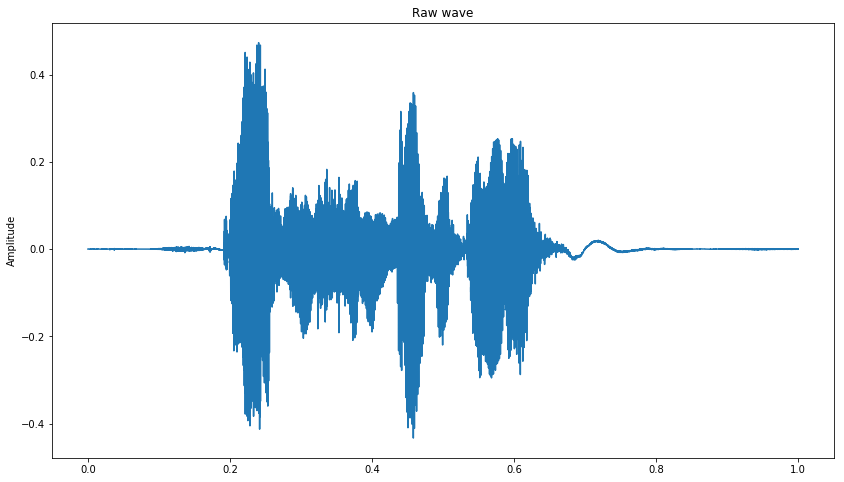

In [0]:
aaa =data2_df.path[216].replace('data/','')
url = (link+ aaa)
X, sample_rate = librosa.load(url, res_type = 'kaiser_fast', duration =4, sr = 22050*2, offset = 0.5)
plot_time_series(X)
ipd.Audio(X, rate = sample_rate)

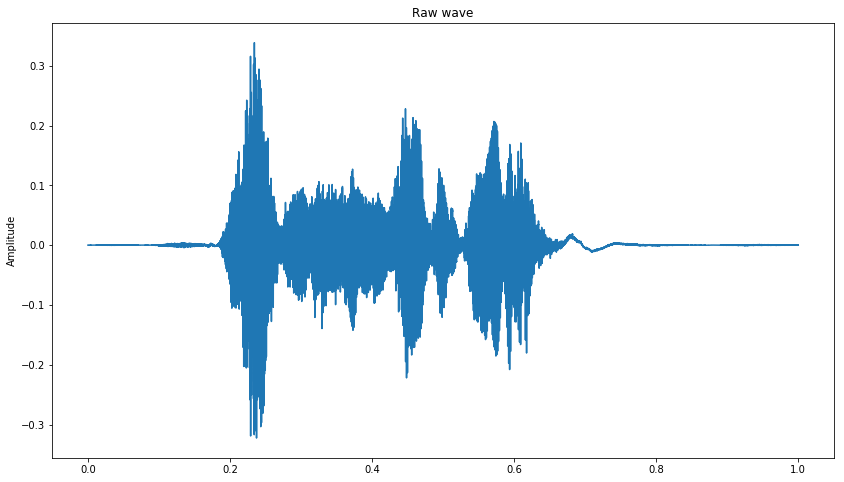

In [0]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate  = sample_rate)

In [0]:
#Agumentation method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    aaa =data2_df.path[i].replace('data/','')
    url = (link+ aaa)
    X, sample_rate = librosa.load(url, res_type ='kaiser_fast', duration =input_duration,sr = 22050* 2, offset = 0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr = sample_rate, n_mfcc = 13), axis = 0)
        feature = mfccs
        a = random.uniform(0,1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 400/400 [01:17<00:00,  5.23it/s]


In [0]:
#Agumentation method  2

syn_data2 = pd.DataFrame(columns = ['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    aaa =data2_df.path[i].replace('data/','')
    url = (link+ aaa)
    X, sample_rate= librosa.load(url, res_type = 'kaiser_fast', duration = input_duration, sr = 22050*2, offset = 0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr = sample_rate, n_mfcc = 13), axis =0)
        feature = mfccs
        a = random.uniform(0,1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]
        

100%|██████████| 400/400 [02:46<00:00,  2.39it/s]


In [0]:
len(syn_data1),len(syn_data2)

(400, 400)

In [0]:
syn_data1 = syn_data1.reset_index(drop= True)
syn_data2 = syn_data2.reset_index(drop= True)


In [0]:
df4= pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syn_df1 = pd.concat([df4, labels4], axis =1)
syn_df1 = syn_df1.rename(index= str, columns= {"0":"label"})
syn_df1 =syn_df1.fillna(0)
len(syn_df1)

400

In [0]:
syn_df1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-38.471060,-37.593822,-36.811046,-38.036404,-38.518416,-38.775776,-38.463277,-36.029443,-35.384814,-34.347491,-34.756614,-38.061341,-35.525671,-33.804070,-34.634326,-36.347411,-33.688969,-34.111339,-35.527110,-36.296945,-36.112824,-35.968041,-37.738224,-37.357970,-37.074033,-36.439677,-37.640132,-36.672499,-35.765402,-35.868776,-37.342660,-37.842129,-36.717998,-34.967363,-34.917192,-33.053132,-29.337736,-25.245588,-25.444735,-27.381432,...,-32.425810,-32.005198,-31.852224,-35.015977,-33.497006,-33.915233,-36.362779,-34.682889,-35.213093,-35.136231,-37.285950,-38.353126,-37.722549,-37.000077,-37.876573,-37.834581,-37.451717,-37.365934,-38.969754,-39.967249,-38.539611,-38.084329,-37.913755,-36.768803,-35.996494,-35.678049,-36.951849,-37.052454,-38.135693,-39.782917,-36.878039,-36.230590,-37.245159,-38.914656,-39.072613,-39.518895,-39.687727,-39.177460,-40.517177,male_fearful
1,-40.505282,-39.275795,-40.301527,-40.019112,-40.618039,-41.603185,-40.799228,-41.356478,-41.480565,-40.971322,-39.461902,-41.469637,-41.146529,-42.157663,-43.103302,-42.041372,-42.050453,-43.317894,-43.682725,-43.963424,-43.771491,-44.176615,-43.582032,-40.446943,-38.879521,-38.632049,-39.857861,-38.198314,-36.345770,-35.549500,-33.537236,-32.424904,-32.373009,-33.881176,-37.745078,-39.034077,-41.709488,-43.141187,-40.119512,-40.594060,...,-23.204738,-26.312640,-25.780987,-25.528664,-27.211862,-26.222262,-24.377765,-25.041220,-25.042736,-23.821195,-25.355881,-25.220771,-25.845693,-27.748442,-28.508549,-27.993591,-28.846061,-28.931470,-31.782544,-31.985663,-29.640419,-29.084058,-28.668580,-28.234119,-28.428000,-30.397306,-33.869108,-35.134412,-34.682194,-33.661892,-34.799793,-35.430326,-37.010470,-38.409204,-39.749312,-39.514444,-38.934274,-39.086436,-39.934609,male_angry
2,-63.675005,-62.421986,-62.445739,-64.209901,-62.803887,-63.668883,-62.888611,-61.771417,-62.119537,-58.140290,-59.367377,-63.666751,-60.922835,-58.614856,-59.780202,-57.824196,-55.661888,-53.470918,-54.158579,-55.603426,-53.933914,-55.046380,-56.577002,-53.750844,-53.395037,-55.228657,-57.121678,-54.731574,-52.802736,-54.970387,-55.460227,-57.263636,-60.613735,-61.448580,-58.780705,-58.392836,-58.848052,-57.242430,-54.242455,-55.976370,...,-63.892094,-64.319346,-64.021181,-64.494453,-63.469949,-62.587244,-62.441723,-63.570937,-64.737216,-64.933863,-62.225272,-62.362249,-63.275751,-63.527557,-63.360885,-63.589937,-64.519510,-63.940562,-61.385800,-60.976848,-62.053191,-64.050419,-63.948285,-63.260759,-64.020546,-64.016678,-64.729728,-63.825322,-63.466531,-64.518057,-64.050881,-63.049486,-63.899463,-64.924514,-65.083286,-63.183257,-62.112917,-62.949232,-64.348830,male_happy
3,-39.590291,-40.161972,-39.698053,-38.701494,-38.949760,-39.035984,-38.976247,-39.000635,-39.066797,-39.662386,-38.492714,-37.562778,-39.161683,-39.644420,-38.877320,-38.472740,-37.932949,-37.415709,-38.560343,-37.503568,-37.834279,-37.301326,-36.507116,-37.050089,-35.901977,-36.234662,-37.433563,-38.709551,-36.029057,-34.934682,-34.159088,-35.390188,-34.293256,-32.291169,-33.598110,-33.926183,-32.302019,-32.671707,-27.199990,-26.257634,...,-20.211800,-19.900252,-19.179393,-19.451751,-21.231019,-23.878202,-23.666802,-23.818358,-20.903364,-19.603465,-21.733893,-19.291621,-18.251692,-20.445682,-20.669231,-19.129724,-19.161446,-20.544375,-18.902404,-17.441792,-17.505468,-17.972820,-18.754607,-18.837388,-19.353680,-20.334976,-21.391195,-23.396145,-23.490702,-23.918635,-25.411479,-28.757372,-28.182196,-28.625308,-29.056347,-31.979643,-30.969688,-31.093407,-31.301782,male_angry
4,-55.044858,-56.172086,-59.598040,-57.661438,-56.538631,-57.676739,-59.087100,-57.038517,-56.357000,-55.088176,-55.196452,-55.422475,-55.683913,-56.537905,-56.002519,-56.629905

In [0]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4= syn_data2.label
syn_df2 = pd.concat([df4, labels4], axis =1)
syn_df2= syn_df2.rename(index =str, columns = {'0':'label'})
syn_df2 = syn_df2.fillna(0)
len(syn_df2)

400

In [0]:
syn_df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-40.613281,-43.651503,-44.559831,-44.523276,-43.756985,-43.606623,-44.242787,-44.742187,-43.318120,-41.703226,-42.336355,-43.783977,-42.198000,-43.138553,-43.691013,-43.126871,-42.653231,-43.492953,-42.954774,-42.597399,-44.136327,-44.798954,-44.401349,-44.566025,-44.701407,-44.929399,-42.716969,-42.286161,-42.544684,-42.778016,-42.472582,-42.556986,-42.795106,-41.719710,-38.510803,-36.105584,-33.558783,-29.753030,-27.503262,-29.553245,...,-39.456253,-40.105165,-40.718936,-41.058961,-38.779856,-39.543669,-41.547705,-41.572279,-41.958228,-42.375440,-43.308472,-44.736276,-42.909697,-42.609919,-43.151069,-44.701169,-44.928270,-44.546426,-44.120470,-44.995873,-44.995873,-44.995873,-44.995873,-44.995873,-44.995873,-45.044112,-44.998054,-44.908290,-45.174830,-45.096957,-45.059187,-45.174116,-44.867933,-44.527783,-44.282363,-44.756376,-45.197226,-45.191402,-45.122943,male_fearful
1,-43.084700,-43.488431,-45.037697,-45.444778,-45.826516,-45.256746,-45.579410,-45.858462,-45.773916,-45.141056,-45.194306,-45.671189,-45.178343,-45.181283,-46.053965,-46.257361,-46.504344,-46.955655,-47.549425,-47.584204,-47.355252,-46.954611,-45.927975,-44.363832,-43.010791,-42.231423,-41.534986,-42.372381,-42.301822,-41.799402,-39.777305,-39.316159,-40.778910,-40.284213,-42.819852,-45.542277,-45.446298,-46.148410,-46.917750,-46.605186,...,-31.486219,-32.558156,-33.215710,-32.984766,-33.449893,-32.449946,-31.304009,-32.037235,-31.194345,-29.837655,-31.143902,-32.425452,-31.665905,-31.972087,-32.830435,-33.166174,-34.026075,-34.848636,-35.865087,-37.356997,-35.858703,-34.553078,-34.088325,-33.927278,-34.616959,-36.369464,-38.051012,-40.136356,-40.659645,-39.737556,-40.481024,-41.369610,-41.689872,-43.353063,-43.815704,-43.518365,-43.684957,-44.327699,-45.178706,male_angry
2,-68.079390,-67.785552,-67.886688,-68.079390,-68.079390,-68.079390,-67.925280,-68.076214,-65.713216,-62.574566,-63.895001,-65.931043,-68.022500,-63.993792,-63.370665,-62.279653,-59.034766,-56.872939,-56.730679,-58.966139,-59.942032,-60.800994,-60.626071,-61.053085,-59.230541,-59.493661,-59.851330,-59.853978,-59.353839,-58.519928,-60.039627,-61.339609,-63.095069,-63.274796,-64.335760,-63.413901,-63.300962,-62.902608,-60.482859,-58.899161,...,-68.079390,-68.079390,-68.079390,-68.079390,-68.079390,-68.079390,-68.079390,-68.079390,-68.079390,-68.079390,-68.079390,-68.079390,-67.969486,-67.921049,-68.079390,-68.079390,-67.212427,-66.143860,-65.457115,-65.290503,-67.130653,-68.079390,-67.527895,-68.056376,-68.079390,-68.079390,-68.079390,-68.079390,-68.079390,-68.079390,-68.079390,-68.079390,-68.079390,-68.079390,-68.079390,-68.079390,-68.079390,-68.079390,-68.079390,male_happy
3,-43.967822,-43.912840,-43.876853,-44.029792,-43.907189,-43.847463,-44.116982,-44.244609,-44.156648,-44.454206,-44.655295,-44.282250,-43.951352,-44.316337,-44.264413,-43.542434,-43.322320,-42.845985,-42.521739,-43.436439,-43.616062,-42.784415,-42.384600,-43.205081,-41.746695,-40.574387,-40.363994,-41.531723,-42.178404,-40.740531,-39.571990,-39.033567,-38.706495,-39.188604,-39.464057,-39.110103,-37.856784,-34.604466,-30.925086,-30.134891,...,-24.464787,-24.301152,-24.561431,-25.401526,-25.749145,-28.520933,-30.033186,-27.757017,-25.864196,-25.011583,-25.331835,-23.398524,-23.819073,-24.437072,-23.619999,-23.662363,-23.816209,-23.258169,-22.512797,-21.050218,-20.990326,-21.656127,-22.265961,-22.312947,-23.414002,-24.210644,-24.781265,-25.632768,-26.872711,-28.223223,-30.150889,-32.227752,-32.453826,-32.368837,-33.556194,-36.443625,-36.283814,-35.035083,-32.694554,male_angry
4,-70.594601,-70.910793,-70.910793,-70.910793,-70.910793,-70.910793,-70.910793,-70.910793,-70.910793,-70.292305,-70.130260,-70.533043,-70.910793,-70.910793,-70.910793,-70.910793

In [0]:
#Combining the agumented data with original
combined_df =pd.concat([rnewdf, syn_df1, syn_df2], ignore_index = True)
conbined_df =combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-37.497485,-40.120203,-41.299181,-42.205225,-42.010662,-42.347005,-41.992263,-40.100020,-38.743483,-38.762679,-38.372811,-39.614612,-39.552965,-37.963736,-38.624763,-40.294831,-38.821838,-39.816715,-39.472309,-40.445240,-42.660727,-43.218548,-44.757159,-45.186342,-42.057724,-40.432836,-40.951919,-40.406351,-41.190680,-41.249963,-41.729170,-41.005234,-40.677677,-40.151354,-38.249552,-35.924200,-31.023413,-26.318126,-26.010123,-27.582792,...,-34.813604,-34.822896,-35.506122,-37.812147,-35.614462,-34.832096,-38.062504,-39.837901,-39.093646,-38.306913,-41.094441,-43.434754,-41.904384,-40.995234,-40.603677,-41.728876,-44.298181,-44.140010,-43.460900,-44.379043,-45.149577,-45.149577,-45.149577,-44.613174,-45.016475,-44.386598,-45.076157,-44.130606,-45.271260,-45.474085,-45.210172,-45.572336,-44.962967,-44.330655,-44.523276,-43.964656,-44.769628,-45.668445,-45.776880,male_fearful
1,-42.103941,-42.229003,-44.166609,-43.172731,-43.590565,-42.570869,-43.202092,-43.710552,-43.444093,-43.015801,-42.674255,-43.179080,-43.643285,-43.392419,-44.261899,-44.332586,-44.791390,-45.854885,-45.802276,-45.877132,-45.784065,-46.308079,-46.047460,-43.609270,-41.067687,-40.265429,-40.225973,-37.467557,-36.944347,-35.780107,-34.161108,-32.850324,-33.375582,-36.425046,-40.158574,-40.933119,-41.804807,-44.573514,-43.242841,-41.542918,...,-24.598326,-25.815471,-26.566965,-26.817742,-27.274248,-26.150922,-24.225770,-25.045295,-25.449227,-24.353812,-25.741875,-25.726782,-26.266498,-28.130974,-29.092512,-28.474051,-29.504437,-30.227491,-33.063456,-33.653645,-30.587607,-29.670955,-29.334154,-28.656382,-29.761241,-32.423828,-35.015802,-36.489553,-36.218625,-35.627007,-36.795598,-37.114313,-38.255681,-39.187163,-40.170768,-40.436697,-40.436664,-40.797505,-42.334028,male_angry
2,-65.427316,-65.427316,-65.261778,-65.427316,-65.427316,-65.427316,-65.027579,-65.404326,-65.427316,-58.999030,-59.859934,-65.427316,-64.953885,-62.659549,-60.537833,-57.967072,-55.975075,-53.762560,-54.547562,-56.750144,-54.922565,-55.847289,-57.197226,-54.213751,-54.295153,-56.156418,-57.935682,-55.399261,-53.531630,-55.814502,-56.429127,-57.985399,-60.487362,-61.382497,-60.111186,-59.446015,-59.366064,-58.300638,-55.535303,-57.611885,...,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.035729,-65.427316,-65.379514,-65.403893,-65.427316,-65.427316,-65.397810,-64.413847,-63.135950,-62.677042,-63.732225,-65.427316,-65.196555,-65.143654,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,-65.427316,male_happy
3,-40.796900,-40.789688,-40.808360,-40.876579,-40.619732,-40.420137,-40.692867,-40.931260,-40.967248,-40.788015,-41.156290,-40.884695,-40.863337,-40.580276,-40.801963,-40.409169,-40.380482,-40.049638,-39.760711,-39.562677,-40.276822,-39.813076,-39.366145,-39.746898,-38.260422,-37.855342,-38.322640,-39.684310,-38.506191,-37.629718,-37.561672,-36.421509,-35.744851,-34.193258,-34.841847,-34.754843,-34.193631,-34.152334,-27.991570,-27.324652,...,-20.866933,-20.123587,-18.770808,-19.729669,-21.803526,-23.884525,-23.195948,-23.707877,-20.299234,-19.903132,-22.044339,-19.084277,-18.711177,-20.470550,-20.620604,-19.807115,-19.517610,-20.579946,-19.085449,-17.449445,-17.537432,-18.067180,-18.966682,-19.037800,-19.709788,-21.236731,-22.384937,-23.647447,-24.330768,-24.810002,-26.737478,-29.418206,-28.891692,-29.568129,-32.069784,-33.713040,-32.310781,-31.767998,-32.521598,male_angry
4,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,-67.251427,-69.333558,-69.693311,-69.693311,-69.647573,-69.679308

In [0]:
#Stratified shuffle split

X= combined_df.drop(['label'],axis =1)
y = combined_df.label

xxx= StratifiedShuffleSplit(1, test_size = 0.2, random_state= 12)
for train_index, test_index in xxx.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [0]:
y_train.value_counts()

male_angry      192
male_fearful    192
male_calm       192
male_sad        192
male_happy      192
Name: label, dtype: int64

In [0]:
y_test.value_counts()

male_angry      48
male_calm       48
male_fearful    48
male_sad        48
male_happy      48
Name: label, dtype: int64

In [0]:
X_train.isna().sum().sum()

0

In [0]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


In [0]:
y_train

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [0]:
y_train.shape

(960, 5)

In [0]:
X_train.shape

(960, 259)

# **Changing demension for CNN model**

In [0]:
x_train_cnn = np.expand_dims(X_train, axis =2 )
# print(x_train_cnn)
x_test_cnn = np.expand_dims(X_test, axis = 2)
# print(x_test_cnn)

In [0]:
#set up keras  util functions
from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true* y_pred, 0,1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred,0,1)))
    precision =  true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0 ,1 ))) == 0 :
        return 0
    p = precision(y_true, y_pred)
    r = recall(y_true,y_pred)
    f_score = 2* (p* r)/ (p+r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [0]:
# MODEL
# model = Sequential()
# model.add(Conv1D(256,10, padding ='same', input_shape=(X_train.shape[1],1))) #1
# model.add(Activation('relu'))

# model.add(Conv1D(256,10, padding = 'same')) #2
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size=(10)))
# model.add(Conv1D(128, 10, padding= 'same')) #3
# model.add(Activation('relu'))

# model.add(Conv1D(128, 10, padding='same')) #4
# model.add(Activation('relu'))

# model.add(Conv1D(128, 10, padding='same')) #5
# model.add(Activation('relu'))

# model.add(Conv1D(128, 10, padding='same')) #6
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size = (10)))
# model.add(Conv1D(64,10,padding ='same')) #7
# model.add(Activation('relu'))

# model.add(Conv1D(64,10,padding = 'same')) #8
# model.add(Activation('relu'))

# model.add(Flatten())

# #Edit according to target class no
# model.add(Dense(10))
# # model.add(Dense(target_class)) #9
# model.add(Activation('softmax'))
# opt =keras.optimizers.SGD(lr = 0.0001, momentum =0.0, decay =0.0, nesterov = False)

In [0]:
# MODEL
model = Sequential()
model.add(Conv1D(256,8, padding ='same', input_shape=(X_train.shape[1],1))) #1
model.add(Activation('relu'))

model.add(Conv1D(256,8, padding = 'same')) #2
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding= 'same')) #3
model.add(Activation('relu'))

model.add(Conv1D(128, 8, padding='same')) #4
model.add(Activation('relu'))

model.add(Conv1D(128, 8, padding='same')) #5
model.add(Activation('relu'))

model.add(Conv1D(128, 8, padding='same')) #6
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size = (8)))
model.add(Conv1D(64,8,padding ='same')) #7
model.add(Activation('relu'))

model.add(Conv1D(64,8,padding = 'same')) #8
model.add(Activation('relu'))

model.add(Flatten())

#Edit according to target class no
model.add(Dense(5))
# model.add(Dense(target_class)) #9
model.add(Activation('softmax'))
opt =keras.optimizers.SGD(lr = 0.0001, momentum =0.0, decay =0.0, nesterov = False)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
# Original Model

# model = Sequential()
# model.add(Conv1D(256, 5,padding='same', input_shape=(X_train.shape[1],1)))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.1))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(5))
# model.add(Activation('softmax'))
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)  

In [0]:
#Plotting model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 259, 256)          2304      
_________________________________________________________________
activation_1 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 259, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 256)          

In [0]:
#Compile model
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics =['accuracy', fscore])

# Removed the whole training part for avoiding unnecessary long epochs **list**

In [0]:
#Model training
#train on 960 samples va validation on 240 samples

lr_reduce = ReduceLROnPlateau(monitor ='val_loss', factor =0.9, patience = 20, min_lr =0.000001)

mcp_save = ModelCheckpoint((root_path+'/model/speech_5labels_ver2.h5'), save_best_only=True, monitor ='val_loss', mode = 'min')
cnn_history = model.fit(x_train_cnn, y_train, batch_size = 16, epochs=700,validation_data=(x_test_cnn, y_test),
                       callbacks=[mcp_save, lr_reduce])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 960 samples, validate on 240 samples
Epoch 1/700
960/960 [==============================] - 8s 8ms/step - loss: 1.5940 - acc: 0.2687 - fscore: 0.0000e+00 - val_loss: 1.5623 - val_acc: 0.2750 - val_fscore: 0.0000e+00
Epoch 2/700
960/960 [==============================] - 2s 2ms/step - loss: 1.4907 - acc: 0.3635 - fscore: 0.0059 - val_loss: 1.5341 - val_acc: 0.3083 - val_fscore: 0.0000e+00
Epoch 3/700
960/960 [==============================] - 2s 2ms/step - loss: 1.4282 - acc: 0.3979 - fscore: 0.0328 - val_loss: 1.5058 - val_acc: 0.3500 - val_fscore: 0.0000e+00
Epoch 4/700
960/960 [==============================] - 2s 2ms/step - loss: 1.3918 - acc: 0.4219 - fscore: 0.0707 - val_loss: 1.4880 - val_acc: 0.3583 - val_fscore: 0.0000e+00
Epoch 5/700
960/960 [==============================] - 2s 2ms/step - loss: 1.3884 - acc: 0.4490 - fscore: 0.0791 - val_loss: 1.4697 - val_acc: 0.3875 - val_

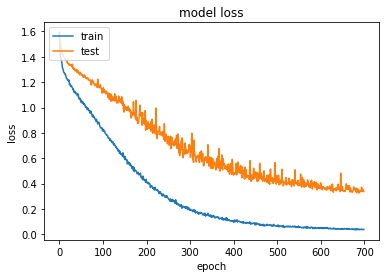

In [0]:
#Plotting the Train valid loss graph

plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc ='upper left')
plt.show()

# Saving Model

In [0]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# **Loading model**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

# !fusermount -u drive
# !google-drive-ocamlfuse drive

Mounted at /content/gdrive


In [0]:
#Loading json and create model

from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model =  model_from_json(loaded_model_json)
print(loaded_model_json)
#load weights into new model
url = root_path+'/model/speech_5labels_ver2.h5'
print(url)
loaded_model.load_weights(url)
print("loaded model from drive")

# #evalute loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_test_cnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "Conv1D", "config": {"name": "conv1d_1", "trainable": true, "batch_input_shape": [null, 259, 1], "dtype": "float32", "filters": 256, "kernel_size": [8], "strides": [1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1], "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Activation", "config": {"name": "activation_1", "trainable": true, "dtype": "float32", "activation": "relu"}}, {"class_name": "Conv1D", "config": {"name": "conv1d_2", "trainable": true, "dtype": "float32", "filters": 256, "kernel_size": [8], "strides": [1], "padding": "

# **Predicting emotions on the test data**

In [0]:
print(data3_df.label)

0         male_sad
1       male_angry
2     male_fearful
3        male_calm
4       male_happy
5        male_calm
6       male_happy
7        male_calm
8       male_angry
9        male_calm
10      male_angry
11       male_calm
12        male_sad
13      male_angry
14       male_calm
15      male_angry
16    male_fearful
17      male_angry
18       male_calm
19    male_fearful
20       male_calm
21    male_fearful
22        male_sad
23      male_happy
24      male_happy
25      male_happy
26      male_happy
27    male_fearful
28        male_sad
29        male_sad
          ...     
50        male_sad
51        male_sad
52       male_calm
53      male_happy
54      male_happy
55       male_calm
56    male_fearful
57      male_happy
58        male_sad
59      male_angry
60       male_calm
61      male_happy
62    male_fearful
63        male_sad
64      male_angry
65      male_happy
66        male_sad
67       male_calm
68        male_sad
69      male_angry
70      male_happy
71       mal

In [0]:
len(data3_df)

80

In [0]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    aaa =data2_df.path[i].replace('data/','')
    url = (link+ aaa)
    X, sample_rate= librosa.load(url, res_type='kaiser_fast',duration = input_duration,sr = 22050*2, offset = 0.5)
#     X = X[10000:90000]
    sample_rate =np.array(sample_rate)
    mfccs =np.mean(librosa.feature.mfcc(y=X, sr = sample_rate, n_mfcc =13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]

test_valid= pd.DataFrame(data_test['feature'].values.tolist())
test_valid =np.array(test_valid)
test_valid_lb =np.array(data3_df.label)
lb=LabelEncoder()
test_valid_lb= np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid,axis =2)
print(test_valid)


100%|██████████| 80/80 [00:21<00:00,  3.74it/s]

[[[-37.49748505]
  [-40.12020315]
  [-41.29918139]
  ...
  [-44.76962771]
  [-45.66844522]
  [-45.77688027]]

 [[-42.10394103]
  [-42.22900342]
  [-44.16660888]
  ...
  [-40.4366638 ]
  [-40.79750533]
  [-42.33402844]]

 [[-65.42731582]
  [-65.42731582]
  [-65.26177811]
  ...
  [-65.42731582]
  [-65.42731582]
  [-65.42731582]]

 ...

 [[-52.58337988]
  [-54.16574487]
  [-54.63343468]
  ...
  [-49.63538155]
  [-48.08278758]
  [-47.41371367]]

 [[-40.84532847]
  [-40.69587275]
  [-40.82833288]
  ...
  [-22.04485545]
  [-22.8969368 ]
  [-23.99229448]]

 [[-60.24429033]
  [-60.20178505]
  [-60.1939896 ]
  ...
  [-46.55292899]
  [-46.11322119]
  [-47.42771667]]]


In [0]:
# print(test_valid_lb)
preds = loaded_model.predict(test_valid,
                            batch_size = 16,
                            verbose =1)

80/80 [==============================] - 0s 4ms/step


In [0]:
preds

array([[7.68726179e-03, 5.15371386e-04, 9.42874551e-01, 2.12993398e-02,
        2.76233777e-02],
       [9.04953539e-01, 2.18931935e-03, 1.83924269e-02, 6.12764396e-02,
        1.31882774e-02],
       [4.03660089e-02, 2.76976563e-02, 1.97304171e-02, 8.78186166e-01,
        3.40197533e-02],
       [9.50344026e-01, 1.86492736e-03, 3.60115431e-02, 1.08370408e-02,
        9.42394545e-04],
       [3.44251818e-03, 9.71308410e-01, 3.79989651e-04, 8.23804236e-04,
        2.40452997e-02],
       [4.93016606e-03, 1.28870801e-04, 9.90454853e-01, 4.28010942e-03,
        2.05982869e-04],
       [6.14352785e-02, 2.44869478e-02, 8.45238209e-01, 3.88466232e-02,
        2.99930125e-02],
       [8.16763937e-03, 1.84746664e-02, 6.05285587e-03, 1.56288873e-02,
        9.51676011e-01],
       [6.47893501e-03, 3.29599949e-04, 1.00273611e-02, 9.76499498e-01,
        6.66452898e-03],
       [4.83231444e-04, 9.96125758e-01, 1.72686574e-04, 1.33386697e-03,
        1.88448699e-03],
       [3.95888323e-03, 2.7625

In [0]:
preds1=preds.argmax(axis =1)

In [0]:
preds1

array([2, 0, 3, 0, 1, 2, 2, 4, 3, 1, 4, 2, 0, 0, 1, 3, 4, 3, 4, 4, 4, 1,
       2, 3, 1, 3, 4, 2, 1, 3, 3, 0, 0, 2, 4, 0, 0, 1, 4, 1, 1, 2, 1, 3,
       0, 0, 0, 4, 2, 1, 0, 3, 0, 1, 3, 4, 4, 1, 4, 4, 2, 0, 3, 3, 4, 3,
       4, 4, 2, 1, 2, 4, 3, 1, 2, 3, 0, 2, 0, 1])

In [0]:
zxc = preds1.astype(int).flatten()
print(zxc)

[2 0 3 0 1 2 2 4 3 1 4 2 0 0 1 3 4 3 4 4 4 1 2 3 1 3 4 2 1 3 3 0 0 2 4 0 0
 1 4 1 1 2 1 3 0 0 0 4 2 1 0 3 0 1 3 4 4 1 4 4 2 0 3 3 4 3 4 4 2 1 2 4 3 1
 2 3 0 2 0 1]


In [0]:
predict =model.predict(x_test_cnn)
# round predictions 
rounded = [round(x[0]) for x in predict]
print(predict)

[[9.15879607e-01 3.61521430e-02 2.68483646e-02 1.80013515e-02
  3.11859371e-03]
 [7.99301445e-01 2.57660132e-02 4.39902022e-02 8.86080600e-03
  1.22081593e-01]
 [1.26104340e-01 6.30318234e-03 8.58436584e-01 4.57277708e-03
  4.58312873e-03]
 ...
 [2.71259062e-03 1.03980405e-02 7.82209814e-01 5.31450436e-02
  1.51534542e-01]
 [2.50946567e-03 3.69510992e-04 9.55257177e-01 3.72013785e-02
  4.66245366e-03]
 [6.09053195e-01 9.17996764e-02 1.82054862e-02 2.59833127e-01
  2.11084504e-02]]


In [0]:
predictions = (lb.inverse_transform((zxc)))
print(predictions)

['male_fearful' 'male_angry' 'male_happy' 'male_angry' 'male_calm'
 'male_fearful' 'male_fearful' 'male_sad' 'male_happy' 'male_calm'
 'male_sad' 'male_fearful' 'male_angry' 'male_angry' 'male_calm'
 'male_happy' 'male_sad' 'male_happy' 'male_sad' 'male_sad' 'male_sad'
 'male_calm' 'male_fearful' 'male_happy' 'male_calm' 'male_happy'
 'male_sad' 'male_fearful' 'male_calm' 'male_happy' 'male_happy'
 'male_angry' 'male_angry' 'male_fearful' 'male_sad' 'male_angry'
 'male_angry' 'male_calm' 'male_sad' 'male_calm' 'male_calm'
 'male_fearful' 'male_calm' 'male_happy' 'male_angry' 'male_angry'
 'male_angry' 'male_sad' 'male_fearful' 'male_calm' 'male_angry'
 'male_happy' 'male_angry' 'male_calm' 'male_happy' 'male_sad' 'male_sad'
 'male_calm' 'male_sad' 'male_sad' 'male_fearful' 'male_angry'
 'male_happy' 'male_happy' 'male_sad' 'male_happy' 'male_sad' 'male_sad'
 'male_fearful' 'male_calm' 'male_fearful' 'male_sad' 'male_happy'
 'male_calm' 'male_fearful' 'male_happy' 'male_angry' 'male_fea

In [0]:
preddf =pd.DataFrame({'predictedvalues':predictions})
preddf[:10]

,predictedvalues
0,male_fearful
1,male_angry
2,male_happy
3,male_angry
4,male_calm
5,male_fearful
6,male_fearful
7,male_sad
8,male_happy
9,male_calm


In [0]:
actual = test_valid_lb.argmax(axis=1)
zxc123 = actual.astype('int').flatten()
actualvalues = (lb.inverse_transform((zxc123)))

In [0]:
actual_df = pd.DataFrame({'actualvalues':actualvalues})
actual_df[:10]

,actualvalues
0,male_sad
1,male_angry
2,male_fearful
3,male_calm
4,male_happy
5,male_calm
6,male_happy
7,male_calm
8,male_angry
9,male_calm


In [0]:
final_df = actual_df.join(preddf)

# **Actual v/s Predicted emotions**

In [0]:
final_df[20:40]

,actualvalues,predictedvalues
20,male_calm,male_sad
21,male_fearful,male_calm
22,male_sad,male_fearful
23,male_happy,male_happy
24,male_happy,male_calm
25,male_happy,male_happy
26,male_happy,male_sad
27,male_fearful,male_fearful
28,male_sad,male_calm
29,male_sad,male_happy


In [0]:
final_df.groupby('actualvalues').count()

,predictedvalues
actualvalues,
male_angry,16
male_calm,16
male_fearful,16
male_happy,16
male_sad,16


In [0]:
final_df.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
male_angry,16
male_calm,16
male_fearful,14
male_happy,16
male_sad,18


In [0]:
final_df.to_csv('Predictions.csv', index =False)
print(final_df)

    actualvalues predictedvalues
0       male_sad    male_fearful
1     male_angry      male_angry
2   male_fearful      male_happy
3      male_calm      male_angry
4     male_happy       male_calm
5      male_calm    male_fearful
6     male_happy    male_fearful
7      male_calm        male_sad
8     male_angry      male_happy
9      male_calm       male_calm
10    male_angry        male_sad
11     male_calm    male_fearful
12      male_sad      male_angry
13    male_angry      male_angry
14     male_calm       male_calm
15    male_angry      male_happy
16  male_fearful        male_sad
17    male_angry      male_happy
18     male_calm        male_sad
19  male_fearful        male_sad
20     male_calm        male_sad
21  male_fearful       male_calm
22      male_sad    male_fearful
23    male_happy      male_happy
24    male_happy       male_calm
25    male_happy      male_happy
26    male_happy        male_sad
27  male_fearful    male_fearful
28      male_sad       male_calm
29      ma

In [0]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize = 14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm =pd.DataFrame(confusion_matrix, index = class_names,columns =class_names,)
    fig = plt.figure(figsize =figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot = True, fmt ="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation =0, ha ='right', fontsize= fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation =45, ha ='right', fontsize= fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
from sklearn.metrics import accuracy_score
y_true = final_df.actualvalues
y_pred = final_df.predictedvalues
accuracy_score =(y_true, y_pred)*100

In [0]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average ='macro')*100

25.18627450980392

In [0]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[5, 1, 2, 3, 5],
       [4, 3, 3, 0, 6],
       [1, 3, 4, 4, 4],
       [2, 5, 2, 6, 1],
       [4, 4, 3, 3, 2]])

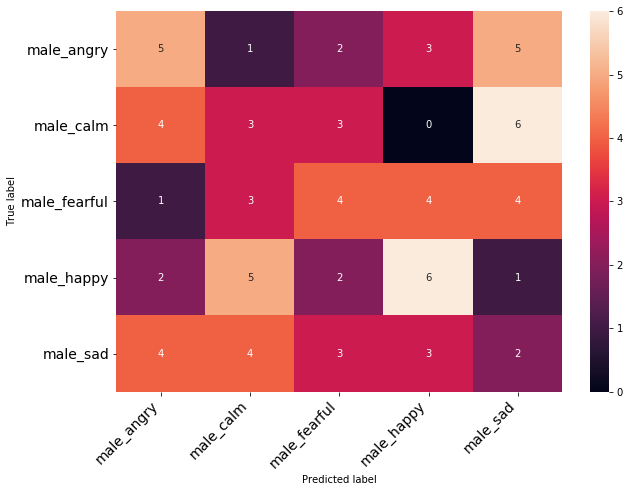

In [0]:
# Visualize Confusion Matrix 

class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
# class_names = ['male_negative', 'male_neutral', 'male_positive']
# class_names = ['male_negative', 'male_positive']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']

# class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_neutral', 'male_sad']
# class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)

In [0]:
print(model_json)

{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "Conv1D", "config": {"name": "conv1d_1", "trainable": true, "batch_input_shape": [null, 259, 1], "dtype": "float32", "filters": 256, "kernel_size": [8], "strides": [1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1], "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Activation", "config": {"name": "activation_1", "trainable": true, "dtype": "float32", "activation": "relu"}}, {"class_name": "Conv1D", "config": {"name": "conv1d_2", "trainable": true, "dtype": "float32", "filters": 256, "kernel_size": [8], "strides": [1], "padding": "

# **DEMO**

In [0]:
link_record = root_path+'/voice_recorded/output10.wav'
data, sampling_rate =librosa.load(link_record)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['random', 'fft', 'repeat', 'std', 'mean', 'f']
`%matplotlib` prevents importing * from pylab and numpy



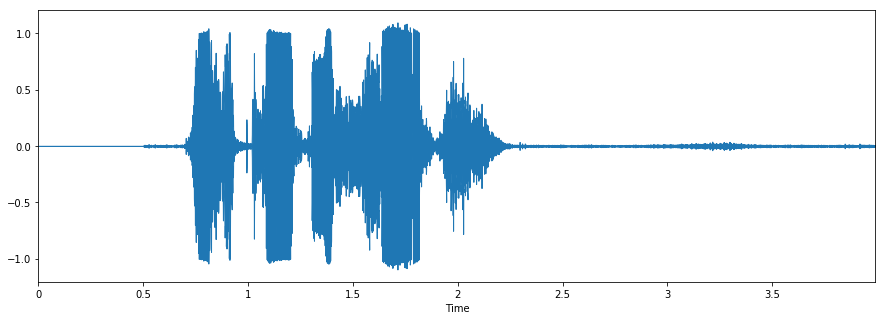

In [0]:
%pylab inline
plt.figure(figsize=(15,5))
librosa.display.waveplot(data, sr= sampling_rate)

In [0]:
livedf = pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load(link_record, res_type='kaiser_fast', duration = input_duration, sr=22050*2,offset = 0.5)
sample_rate= np.array(sample_rate)
mfccs =np.mean(librosa.feature.mfcc(y =X,sr = sample_rate, n_mfcc= 13),axis = 0)
featurelive= mfccs
livedf2 = featurelive

In [0]:
livedf2= pd.DataFrame(data= livedf2)

In [0]:
livedf2= livedf2.stack().to_frame().T

In [0]:
livedf2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,-18.203564,-21.471836,-22.52221,-21.712259,-22.264288,-20.707904,-21.726444,-21.76865,-24.302736,-22.250634,-19.952749,-21.589886,-22.871398,-21.074195,-22.644074,-24.456729,-21.034204,-18.204837,-15.393931,-14.683821,-16.08818,-15.269258,-10.341141,-7.561026,-7.503775,-5.26073,-2.907981,-1.810235,-8.353989,-11.253944,-11.68832,-15.03596,-17.461964,-18.240293,-17.97851,-14.96761,-15.628132,-17.499977,-19.311693,-21.082069,...,-22.741246,-22.987501,-22.604583,-23.768666,-22.811203,-23.572849,-23.176018,-24.488851,-24.902895,-22.863094,-23.569504,-23.565993,-24.539489,-25.364263,-22.648671,-21.49611,-22.560126,-23.094185,-23.491335,-23.527761,-23.022942,-22.89245,-21.54874,-22.38613,-23.431156,-21.300167,-19.98912,-21.429364,-22.955591,-24.016359,-22.78513,-23.019713,-23.659941,-23.969834,-23.233479,-22.946226,-23.466426,-24.562275,-21.585698,-16.922172


In [0]:
twodim = np.expand_dims(livedf2, axis=2)

In [0]:
livepreds = loaded_model.predict(twodim,
                                batch_size =16,
                                verbose =1)

1/1 [==============================] - 0s 65ms/step


In [0]:
livepreds

array([[0.77764785, 0.00905838, 0.20724769, 0.00251348, 0.00353263]],
      dtype=float32)

In [0]:
livepreds1 =livepreds.argmax(axis=1)

In [0]:
live2 = livepreds1.astype(int).flatten()

In [0]:
livepredictions = (lb.inverse_transform(live2))
livepredictions

array(['male_angry'], dtype=object)